# First Section: Imports

In [1]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
from datetime import datetime
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import warnings
from pandas.io.json import json_normalize
import matplotlib.patches as patches


# RQ1

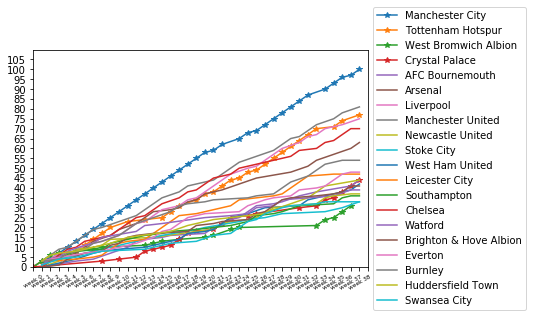

In [2]:
#import json 
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np

#Load the joson files
itMatch = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
team=pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/teams.json')

#load the match.json into list
jf=open('/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
jfs=jf.read()
jfdata=json.loads(jfs)

#clean data -  This drops are need to improve efficiency
#team 
team.drop('area', axis=1, inplace=True)
team.drop('officialName', axis=1, inplace=True)
team.drop('type', axis=1, inplace=True)
team.drop('city', axis=1, inplace=True)

#print('itMatch after\n', itMatch)
#itMatch

#add column with thw two team and remove the teamsData
first=[]
second=[]
for e in jfdata:
    first.append(list(e['teamsData'].keys())[0])
    second.append(list(e['teamsData'].keys())[1])
    
itMatch['team1']=first
itMatch['team2']=second

colToDrop=['seasonId', 'dateutc', 'teamsData', 'venue', 'wyId', 'label', 'referees', 'duration', 'competitionId', 'date']
itMatch.drop(colToDrop, axis=1, inplace=True)

#drop the matches with winner = 0

#rowToDrop=itMatch[itMatch.winner==0]
#itMatch.drop(rowToDrop.index, inplace=True)

#drop the matches that are not played yet
rowToDrop=itMatch.loc[itMatch.status!='Played']
itMatch.drop(rowToDrop.index, inplace=True)

itMatch.drop('status', axis=1, inplace=True)

#divide match into matches winner from someone and matches with a tied 

itMatchWin=itMatch.loc[itMatch['winner']!=0]
#print('itMAtch win\n', itMatchWin)

itMatchTied=itMatch.loc[itMatch['winner']==0]
itMatchTied.drop('winner', axis=1, inplace=True)
#print('itMAtch tied\n', itMatchTied)

#saving in a json file
#export=itMatch.to_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/USmatches_Italy.json')

#Merge win match with team how wins
teamMatchWin=pd.merge(itMatchWin, team, left_on='winner', right_on='wyId', how='outer')

#Merge tied match with the two teams of the match
itMatchTied.loc[:,('team1')]=itMatchTied.loc[:, ('team1')].astype(int)
itMatchTied.loc[:,('team2')]=itMatchTied.loc[:, ('team2')].astype(int)
teamMatchTied=pd.merge(itMatchTied, team, left_on='team1', right_on='wyId', how='outer')
teamMatchTied.rename(columns={'name':'name_1'}, inplace=True)
teamMatchTied=pd.merge(teamMatchTied, team, left_on='team2', right_on='wyId', how='outer')
teamMatchTied.rename(columns={'name':'name_2'}, inplace=True)

# remove some row with NaN value
teamMatchWin.dropna(inplace=True)

teamMatchWin['roundId']=teamMatchWin['roundId'].astype(int)
teamMatchWin['gameweek']=teamMatchWin['gameweek'].astype(int)
teamMatchWin['winner']=teamMatchWin['winner'].astype(int)
#print('teamMatchWin\n', teamMatchWin)


d={}
for index, row in teamMatchWin.iterrows(): #inizilization of a dictionary with k: name of the team and value a list of list; 
                                        #the fist element of internal list is the week, the second is the score
    d[str(row.loc['name'])]=[[0, 0]]


#we  want iterate over whe weeks to add to the dict a pair of (week, score) in order to obtain the point x, y for a plot 


for i in range(1, 39):
    weekI=teamMatchWin.loc[teamMatchWin['gameweek']==i]
    weekIT=teamMatchTied.loc[teamMatchTied['gameweek']==i]
    
    #MatchWin
    
    for index, row in weekI.iterrows():
        #print(row['name'])
        listOfTeam=d[row.loc['name']]
        #print(listOfTeam)
        newScore=listOfTeam[len(listOfTeam)-1][1]+3
        d[row.loc['name']].append([i, newScore])
        
    #MAtchTied
    for index, row in weekIT.iterrows():
        #print(row)
        listOfTeam=d[row.loc['name_1']]
        #print(listOfTeam)
        newScore=listOfTeam[len(listOfTeam)-1][1]+1
        d[row.loc['name_1']].append([i, newScore])
        
        #print(row['name'])
        listOfTeam=d[row.loc['name_2']]
        #print(listOfTeam)
        newScore=listOfTeam[len(listOfTeam)-1][1]+1
        d[row.loc['name_2']].append([i, newScore])

#looking for longhest winning streak and longhest loosing streak
win1=''
win2=''
los1=''
los2=''

#winner

w=''
nw=0
for j in range(2):
    for k, v in d.items():
        #print(k)
        n=0
        prev=v[0]
        for i in range(1, len(v)):
            att=v[i]
            if att[0]==prev[0]+1:
                n+=1
            else:
                if n>nw and k!=win1:
                    nw=n
                    w=k
                n=0
            prev=att
    
    
    nw=0
    if j==0:
        win1=w
    else:
        win2=w

#print('win1 ', win1, 'win2', win2)

#save data of two "winner" to show them separately 
w1=d[win1]
vec1=[i for [i, j] in w1]
wee1=[j for [i, j] in w1]
w2=d[win2]
vec2=[i for [i, j] in w2]
wee2=[j for [i, j] in w2]


#lost
w=''
nw=0
for j in range(2):
    for k, v in d.items():
        #print(k)
        n=0
        prev=v[0]
        for i in range(1, len(v)):
            att=v[i]
            
            n=att[0]-prev[0]
            if n>nw and k!=los1:
                nw=n
                w=k
            n=0
            prev=att
    
    
    nw=0
    if j==0:
        los1=w
    else:
        los2=w

#print('l1 ', los1, 'l2', los2)

#save data of two "lores" to show them separately 
l1=d[los1]
vec1l=[i for [i, j] in l1]
wee1l=[j for [i, j] in l1]
l2=d[los2]
vec2l=[i for [i, j] in l2]
wee2l=[j for [i, j] in l2]


#delete the firt element \[0, 0\] or replace with \[1, 0\] used to star the line from 0 at the firs week
for v in d.values():
    if v[1][0]==1:
        v.pop(0)
    else:
        v[0][0]=1
        
#add the last element used to finish the line ad the 38th week
for v in d.values():
    if v[len(v)-1][0]!=38:
        v.append([38, v[len(v)-1][1]])
        

heigth=110
plt.axis([0, 39, 0, heigth]) #set the length of axis
plt.xticks(range(40), ['week '+str(i) for i in range(39)], rotation=30, fontsize='xx-small') #set the x-ticks, them text and other things 
plt.yticks(list(range(0, heigth, 5))) #set the y-ticks

#we have to plot before the two winners and loosers
plt.plot(vec1, wee1, '*-',  label=win1)
plt.plot(vec2, wee2, '*-',  label=win2)
plt.plot(vec1l, wee1l, '*-', label=los1)
plt.plot(vec2l, wee2l, '*-', label=los2)
#cause we can remove them from dictionary and then print the remaining teams
del d[win1]
del d[win2]
del d[los1]
del d[los2]

#print of the remaining team
for k, v in d.items():
    #vector=[j for [i, j] in v]
    #week=[i for [i, j] in v]
    #print(k, v)
    plt.plot([i for [i, j] in v], [j for [i, j] in v], label=k)


#add legend   
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save picture: the path and file name, the resolution, and the box to fit the image around legend and plot
#plt.savefig('/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/results', format='png', dpi=500, bbox_inches='tight')



plt.show()
   


In [3]:
%reset -f

# RQ2

In [68]:
#import pandas as pd
#from scipy.stats import chi2_contingency
#import numpy as np

def answer_ariss_Question(p):
    h0='Null Hypothesis: there isn\'t an home field advantage'
    h1='Alternate Hypothesis: there is an home field advantage'
    alpha=0.05
    print('We have two Hypotesis:' )
    print(h0 )
    print(h1 )

    print('Our p-value is :{}'.format(p) )
    print('Because ', end='' )
    if(p<0.05):
        print('p-value is less than alpha=0.05, we have to reject the {} and'.format(h0) )
        print('We have to accept the {}'.format(h1) )
    else:
        print('p-value is grader than alpha=0.05, We have to accept the {}'.format(h0) )

In [69]:
def get_contigency_table(team):#teams: set of teamsIds
    match = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
    rowToDrop=match.loc[match.status!='Played']
    match.drop(rowToDrop.index, inplace=True)
    colToDrop=['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'venue', 'label', 'date', 'referees', 'duration', 'competitionId']
    match.drop(colToDrop, axis=1, inplace=True)
    #print(match.head())
    matchOfTeam=pd.DataFrame(columns=['wyId', 'side', 'winner'])#create a dataframe empty
    for idex, row in match.iterrows():#iterate over matches
        teamsDataDict=dict(row['teamsData'])#take the dictionary inside the field teamsData
        keys=list(teamsDataDict.keys())
        k1=keys[0] #take team1 in the match iteration
        k2=keys[1] #take team2 in the match iteration
        if k1==str(team) or k2==str(team):#if teams has only one less elemnt, so only k1 or k2 was remove.
                                        #it means the match includes only one team of our teams
                                        #if teams had only one element, its the same
            
            myRow={}
            teamsData=dict(row['teamsData'])[str(team)]
            #take the infoTeam inside the dictionary of teamsData
            myRow['wyId']=[row['wyId']]
            myRow['side']=teamsData['side']
            myRow['winner']=[row['winner']]
            #and take information about side e winner
            myRowDf=pd.DataFrame(myRow, columns=['wyId', 'side', 'winner']) #create a dataframe to concatenate
            matchOfTeam=pd.concat([matchOfTeam, myRowDf], ignore_index=True) #compose the dataframe
    #now we have a dataframe with all match palyed

    #perform selection on this dataframe in order to fill this table
    #        Win  |  Draw  |  lose
    #------------------------------
    #home |       |        |
    #------------------------------
    #away |       |        |
    #------------------------------

    winHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==team)].shape[0]   #.shape[0] count the number of row
    winAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==team)].shape[0]
    drawHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==0)].shape[0]
    drawAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==0)].shape[0]
    loseHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']!=team) & (matchOfTeam['winner']!=0)].shape[0]
    loseAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']!=team) & (matchOfTeam['winner']!=0)].shape[0]
    arr=np.array([[winHome, drawHome, loseHome], [winAway, drawAway, loseAway]])
    #print(arr)
    return arr


In [70]:

def get_unique_contigency_table(teams):#teams: set of teamsIds
    match = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/matches_England.json')
    rowToDrop=match.loc[match.status!='Played']
    match.drop(rowToDrop.index, inplace=True)
    colToDrop=['status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'venue', 'label', 'date', 'referees', 'duration', 'competitionId']
    match.drop(colToDrop, axis=1, inplace=True)

    matchOfTeam=pd.DataFrame(columns=['wyId', 'side', 'winner'])#create a dataframe empty

    for team in teams:
        for idex, row in match.iterrows():#iterate over matches
            teamsDataDict=dict(row['teamsData'])#take the dictionary inside the field teamsData
            keys=list(teamsDataDict.keys())
            teams_copy=set(teams) #create a copy of our teams
            len_before=len(teams_copy)#the len of teams
            k1=keys[0] #take team1 in the match iteration
            k2=keys[1] #take team2 in the match iteration
            #print(keys)
            #print('teams before: ', teams_copy, '\n k1: {}, k2: {}'.format(k1, k2))
            teams_copy.discard(int(k1)) #delete team1 from the set of teams if it's present
            teams_copy.discard(int(k2)) #delete team2 from the set of teams if it's present
            #print('tems after: ', teams_copy)
            if len(teams_copy)==len_before-1:#if teams has only one less elemnt, so only k1 or k2 was remove.
                                            #it means the match includes only one team of our teams
                myRow={}
                infoTeam=list(teamsDataDict.values())[0] if keys[0]==str(team) else list(teamsDataDict.values())[1]
                #take the infoTeam inside the dictionary of teamsData
                myRow['wyId']=[row['wyId']]
                myRow['side']=[infoTeam['side']]
                myRow['winner']=[row['winner']]
                #and take information about side e winner
                myRowDf=pd.DataFrame(myRow, columns=['wyId', 'side', 'winner']) #create a dataframe to concatenate
                matchOfTeam=pd.concat([matchOfTeam, myRowDf], ignore_index=True) #compose the dataframe
    #now we have a dataframe with all match palyed

    #perform selection on this dataframe in order to fill this table
    #        Win  |  Draw  |  lose
    #------------------------------
    #home |       |        |
    #------------------------------
    #away |       |        |
    #------------------------------

    winHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==team)]   #.shape[0] count the number of row
    winHome.drop_duplicates(inplace=True)
    winHome=winHome.shape[0]
    winAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==team)]
    winAway.drop_duplicates(inplace=True)
    winAway=winAway.shape[0]
    drawHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']==0)]
    drawHome.drop_duplicates(inplace=True)
    drawHome=drawHome.shape[0]
    drawAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']==0)]
    drawAway.drop_duplicates(inplace=True)
    drawAway=drawAway.shape[0]
    loseHome= matchOfTeam.loc[(matchOfTeam['side']=='home') & (matchOfTeam['winner']!=team)]
    loseHome.drop_duplicates(inplace=True)
    loseHome=loseHome.shape[0]
    loseAway= matchOfTeam.loc[(matchOfTeam['side']=='away') & (matchOfTeam['winner']!=team)]
    loseAway.drop_duplicates(inplace=True)
    loseAway=loseAway.shape[0]

    #print(matchOfTeam)
    #print(winHome)
    arr=np.array([[winHome, drawHome, loseHome], [winAway, drawAway, loseAway]])
    #print(arr)
    return arr



#print('ok')

In [71]:
#We choosed the following 5 teams with their id
Manchester_Utd = 1611
Manchester_city = 1625
Liverpool = 1623
Arsenal = 1609
Chelsea = 1610

with open('/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/matches/Answer_RQ2.txt', 'w') as f:

    
    #Manchester Utd
    print('Team 1\n' )
    contTable=get_contigency_table(Manchester_Utd)
    print('Contingency Table\n', contTable )
    print('' )

    #Manchester_city
    print('Team 2\n' )
    contTable=get_contigency_table(Manchester_city)
    print('Contingency Table\n', contTable )
    print('' )

    #Liverpool
    print('Team 3\n' )
    contTable=get_contigency_table(Liverpool)
    print('Contingency Table\n', contTable )
    print('' )

    #Arsenal
    print('Team 4\n' )
    contTable=get_contigency_table(Arsenal)
    print('Contingency Table\n', contTable )
    print('' )

    #Chelsea
    print('Team 5\n' )
    contTable=get_contigency_table(Chelsea)
    print('Contingency Table\n', contTable )
    print('' )
    

    s=set([Manchester_Utd, Manchester_city, Liverpool, Arsenal, Chelsea])
    uniqeContTable=get_unique_contigency_table(s)
    print('Unique contingecy table: \n', uniqeContTable )
    chi2, p, dof, exp = chi2_contingency(uniqeContTable, correction=False)
    print('chi2 = {}\n p = {}\n dof = {}\n exp:\n{}'.format(chi2, p, dof, exp) )
    answer_ariss_Question(p)
    print('Concludions:\n' )
    print("we have too little data to carry out a meaningful analysis." )
    print("We should also carry out further tests in addition to chi2 in order to better investigate the correlation between the two variables analysed" )


Team 1

Contingency Table
 [[15  2  2]
 [10  4  5]]

Team 2

Contingency Table
 [[16  2  1]
 [16  2  1]]

Team 3

Contingency Table
 [[9 5 5]
 [3 7 9]]

Team 4

Contingency Table
 [[15  2  2]
 [ 4  4 11]]

Team 5

Contingency Table
 [[11  4  4]
 [10  3  6]]

Unique contingecy table: 
 [[ 17  20  94]
 [ 14  24 100]]
chi2 = 0.65781526717758
 p = 0.7197094906598158
 dof = 2
 exp:
[[15.09665428 21.42750929 94.47583643]
 [15.90334572 22.57249071 99.52416357]]
We have two Hypotesis:
Null Hypothesis: there isn't an home field advantage
Alternate Hypothesis: there is an home field advantage
Our p-value is :0.7197094906598158
Because p-value is grader than alpha=0.05, We have to accept the Null Hypothesis: there isn't an home field advantage
Concludions:

we have too little data to carry out a meaningful analysis.
We should also carry out further tests in addition to chi2 in order to better investigate the correlation between the two variables analysed


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [ ]:
%reset -f

<h1> RQ3 </h1>

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
#read json data into pandas datframe
df_teams = pd.read_json ('/users/poojacj/Desktop/adm_hw2/teams.json')

In [3]:
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Esp\u00e9rance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de F\u00fatbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,M\u00f6nchengladbach,Borussia M'gladbach,2454,Borussia VfL M\u00f6nchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [4]:
df_teams.shape

(142, 6)

In [5]:
df_teams.columns.values

array(['city', 'name', 'wyId', 'officialName', 'area', 'type'],
      dtype=object)

In [6]:
df_teams.isna().sum()

city            0
name            0
wyId            0
officialName    0
area            0
type            0
dtype: int64

In [7]:
df_teams.officialName.nunique

<bound method IndexOpsMixin.nunique of 0               Newcastle United FC
1           Real Club Celta de Vigo
2      Reial Club Deportiu Espanyol
3             Deportivo Alav\u00e9s
4                        Levante UD
                   ...             
137                           Spain
138                          Serbia
139                     Switzerland
140                          Poland
141                         Nigeria
Name: officialName, Length: 142, dtype: object>

In [8]:
#filter based on the type of team. 
#choose club teams
df_teams = df_teams[df_teams['type'] ==  "club"]

In [9]:
df_teams[:20]

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Esp\u00e9rance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de F\u00fatbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,M\u00f6nchengladbach,Borussia M'gladbach,2454,Borussia VfL M\u00f6nchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [10]:
#choose the teams in English Premier Leagues (England)
#included Wales because Swansea city AFC is a part of English Premier League
filtered_data = []
for i,x in df_teams['area'].items():
    if (x['name'] == "England") | (x['name'] == "Wales") :
        print(i,x)
        filtered_data.append({'index': i, 'area': x})

0 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
8 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
19 {'name': 'Wales', 'id': '0', 'alpha3code': 'XWA', 'alpha2code': ''}
26 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
27 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
39 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
54 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
55 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
56 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
60 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
65 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
66 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
67 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}
68 {'name': 'England', 'id': '0', 'alpha3code': 'XEN', 

In [11]:
filtered_data = pd.DataFrame(filtered_data)

In [12]:
#setting the index 
filtered_data = filtered_data.set_index('index')

In [13]:
filtered_data

,area
index,
0,"{'name': 'England', 'id': '0', 'alpha3code': '..."
8,"{'name': 'England', 'id': '0', 'alpha3code': '..."
19,"{'name': 'Wales', 'id': '0', 'alpha3code': 'XW..."
26,"{'name': 'England', 'id': '0', 'alpha3code': '..."
27,"{'name': 'England', 'id': '0', 'alpha3code': '..."
39,"{'name': 'England', 'id': '0', 'alpha3code': '..."
54,"{'name': 'England', 'id': '0', 'alpha3code': '..."
55,"{'name': 'England', 'id': '0', 'alpha3code': '..."
56,"{'name': 'England', 'id': '0', 'alpha3code': '..."


In [14]:
#merge teams and filtered dataframes on index
df_teams = df_teams.merge(filtered_data, left_index=True, right_index=True)

In [15]:
df_teams

,city,name,wyId,officialName,area_x,type,area_y
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
19,Swansea,Swansea City,10531,Swansea City AFC,"{'name': 'Wales', 'id': '0', 'alpha3code': 'XW...",club,"{'name': 'Wales', 'id': '0', 'alpha3code': 'XW..."
26,"Bournemouth, Dorset",AFC Bournemouth,1659,AFC Bournemouth,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
27,"Brighton, East Sussex",Brighton & Hove Albion,1651,Brighton & Hove Albion FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
39,"Burnley, Lancashire",Burnley,1646,Burnley FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
54,Leicester,Leicester City,1631,Leicester City FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
55,London,West Ham United,1633,West Ham United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
56,Stoke-on-Trent,Stoke City,1639,Stoke City FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."
60,Watford,Watford,1644,Watford FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'England', 'id': '0', 'alpha3code': '..."


In [16]:
#drop unnecessary columns
df_teams = df_teams.drop(['area_x','area_y', 'name', 'type'], axis=1)

In [17]:
df_teams

,city,wyId,officialName
0,Newcastle upon Tyne,1613,Newcastle United FC
8,"Huddersfield, West Yorkshire",1673,Huddersfield Town FC
19,Swansea,10531,Swansea City AFC
26,"Bournemouth, Dorset",1659,AFC Bournemouth
27,"Brighton, East Sussex",1651,Brighton & Hove Albion FC
39,"Burnley, Lancashire",1646,Burnley FC
54,Leicester,1631,Leicester City FC
55,London,1633,West Ham United FC
56,Stoke-on-Trent,1639,Stoke City FC
60,Watford,1644,Watford FC


In [18]:
#rename the column names
df_teams.columns = ['city','currentTeamId','officialName']

In [19]:
df_teams

,city,currentTeamId,officialName
0,Newcastle upon Tyne,1613,Newcastle United FC
8,"Huddersfield, West Yorkshire",1673,Huddersfield Town FC
19,Swansea,10531,Swansea City AFC
26,"Bournemouth, Dorset",1659,AFC Bournemouth
27,"Brighton, East Sussex",1651,Brighton & Hove Albion FC
39,"Burnley, Lancashire",1646,Burnley FC
54,Leicester,1631,Leicester City FC
55,London,1633,West Ham United FC
56,Stoke-on-Trent,1639,Stoke City FC
60,Watford,1644,Watford FC


In [20]:
#read json data into pandas datframe
df_coaches = pd.read_json('/users/poojacj/Desktop/adm_hw2/coaches.json')

In [21]:
df_coaches.head(10)

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0
5,92894,Ernesto Valverde,Ernesto,,Valverde Tejedor,1964-02-09,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",676
6,3880,Unzué,Juan Carlos,,Unzué Labiano,1967-04-22,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",0
7,17121,D. Schuster,Dirk,,Schuster,1967-12-29,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
8,20454,A. Conte,Antonio,,Conte,1969-07-31,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
9,86604,R. Gareca,Ricardo Alberto,,Gareca Nardi,1958-02-10,"{'id': 32, 'alpha2code': 'AR', 'alpha3code': '...","{'id': 32, 'alpha2code': 'AR', 'alpha3code': '...",0


In [22]:
df_coaches.shape

(208, 9)

In [23]:
df_coaches.columns.values

array(['wyId', 'shortName', 'firstName', 'middleName', 'lastName',
       'birthDate', 'birthArea', 'passportArea', 'currentTeamId'],
      dtype=object)

In [24]:
df_coaches.isna().sum()

wyId             0
shortName        0
firstName        0
middleName       0
lastName         0
birthDate        2
birthArea        0
passportArea     0
currentTeamId    0
dtype: int64

In [25]:
df_coaches.shape

(208, 9)

In [26]:
#drop unnecessary columns
df_coaches = df_coaches.drop(['birthArea', 'passportArea'], axis=1)

In [27]:
df_coaches.head(10)

,wyId,shortName,firstName,middleName,lastName,birthDate,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,0
5,92894,Ernesto Valverde,Ernesto,,Valverde Tejedor,1964-02-09,676
6,3880,Unzué,Juan Carlos,,Unzué Labiano,1967-04-22,0
7,17121,D. Schuster,Dirk,,Schuster,1967-12-29,0
8,20454,A. Conte,Antonio,,Conte,1969-07-31,0
9,86604,R. Gareca,Ricardo Alberto,,Gareca Nardi,1958-02-10,0


In [28]:
#left join the teams and coches dataframes on id
df_merge_col = pd.merge(df_teams, df_coaches, on='currentTeamId', how='left')

In [29]:
df_merge_col.head(10)

,city,currentTeamId,officialName,wyId,shortName,firstName,middleName,lastName,birthDate
0,Newcastle upon Tyne,1613,Newcastle United FC,210700.0,Rafael Benítez,Rafael,,Benítez Maudes,1960-04-16
1,Newcastle upon Tyne,1613,Newcastle United FC,531745.0,Paco,Francisco,,de Míguel Moreno,1973-02-19
2,"Huddersfield, West Yorkshire",1673,Huddersfield Town FC,NaN,NaN,NaN,NaN,NaN,NaN
3,Swansea,10531,Swansea City AFC,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bournemouth, Dorset",1659,AFC Bournemouth,8934.0,E. Howe,Eddie,,Howe,1977-11-29
5,"Brighton, East Sussex",1651,Brighton & Hove Albion FC,8093.0,C. Hughton,Chris,,Hughton,1958-12-11
6,"Burnley, Lancashire",1646,Burnley FC,8880.0,S. Dyche,Sean,,Dyche,1971-06-28
7,Leicester,1631,Leicester City FC,NaN,NaN,NaN,NaN,NaN,NaN
8,London,1633,West Ham United FC,NaN,NaN,NaN,NaN,NaN,NaN
9,Stoke-on-Trent,1639,Stoke City FC,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#drop the rows with empty date of birth values
df_merge_col = df_merge_col.dropna(axis = 0, how ='any')

In [31]:
#convert the birthdate datatype to datetime for calculation of age 
df_merge_col['birthdate_datetime'] = pd.to_datetime(df_merge_col.birthDate, infer_datetime_format=True)

In [32]:
df_merge_col['birthdate_datetime']

0    1960-04-16
1    1973-02-19
4    1977-11-29
5    1958-12-11
6    1971-06-28
10   1970-05-01
11   1977-07-12
13   1971-01-18
14   1972-03-02
15   1947-08-09
16   1967-08-09
17   1967-06-16
18   1959-01-10
20   1971-11-03
Name: birthdate_datetime, dtype: datetime64[ns]

In [33]:
#calculate the age of coaches
df_merge_col['age'] = ((pd.to_datetime('today') - df_merge_col['birthdate_datetime'])/365).dt.days

In [34]:
df_merge_col['age']

0     59
1     46
4     41
5     60
6     48
10    49
11    42
13    48
14    47
15    72
16    52
17    52
18    60
20    48
Name: age, dtype: int64

In [35]:
df_merge_col

,city,currentTeamId,officialName,wyId,shortName,firstName,middleName,lastName,birthDate,birthdate_datetime,age
0,Newcastle upon Tyne,1613,Newcastle United FC,210700.0,Rafael Benítez,Rafael,,Benítez Maudes,1960-04-16,1960-04-16,59
1,Newcastle upon Tyne,1613,Newcastle United FC,531745.0,Paco,Francisco,,de Míguel Moreno,1973-02-19,1973-02-19,46
4,"Bournemouth, Dorset",1659,AFC Bournemouth,8934.0,E. Howe,Eddie,,Howe,1977-11-29,1977-11-29,41
5,"Brighton, East Sussex",1651,Brighton & Hove Albion FC,8093.0,C. Hughton,Chris,,Hughton,1958-12-11,1958-12-11,60
6,"Burnley, Lancashire",1646,Burnley FC,8880.0,S. Dyche,Sean,,Dyche,1971-06-28,1971-06-28,48
10,Watford,1644,Watford FC,93112.0,Javi Gracia,Javier,,Gracia Carlos,1970-05-01,1970-05-01,49
11,Liverpool,1623,Everton FC,71037.0,Marco Silva,Marco Alexandre,,Saraiva da Silva,1977-07-12,1977-07-12,42
13,Manchester,1625,Manchester City FC,267136.0,Guardiola,Josep,,Guardiola i Sala,1971-01-18,1971-01-18,48
14,London,1624,Tottenham Hotspur FC,292863.0,M. Pochettino,Mauricio Roberto,,Pochettino Trossero,1972-03-02,1972-03-02,47
15,London,1628,Crystal Palace FC,8357.0,R. Hodgson,Roy,,Hodgson,1947-08-09,1947-08-09,72


In [36]:
#sort the columns in ascending order of age
df_age_sorted = df_merge_col.sort_values(by='age', ascending=True)

In [37]:
#select the top 10 rows
df_youngest_coaches = df_age_sorted[:10]

In [38]:
results = df_youngest_coaches[['officialName','shortName','age']]

In [39]:
results.columns = ['TeamName','CoachName','CoachAge']

In [40]:
results

,TeamName,CoachName,CoachAge
4,AFC Bournemouth,E. Howe,41
11,Everton FC,Marco Silva,42
1,Newcastle United FC,Paco,46
14,Tottenham Hotspur FC,M. Pochettino,47
6,Burnley FC,S. Dyche,48
13,Manchester City FC,Guardiola,48
20,Arsenal FC,Unai Emery,48
10,Watford FC,Javi Gracia,49
16,Southampton FC,R. Hasenhüttl,52
17,Liverpool FC,J. Klopp,52


In [41]:
#save the results to a csv file
results.to_csv("/users/poojacj/Desktop/adm_hw2/RQ3/youngest_coaches.csv",index=None)

In [42]:
df_age_sorted

,city,currentTeamId,officialName,wyId,shortName,firstName,middleName,lastName,birthDate,birthdate_datetime,age
4,"Bournemouth, Dorset",1659,AFC Bournemouth,8934.0,E. Howe,Eddie,,Howe,1977-11-29,1977-11-29,41
11,Liverpool,1623,Everton FC,71037.0,Marco Silva,Marco Alexandre,,Saraiva da Silva,1977-07-12,1977-07-12,42
1,Newcastle upon Tyne,1613,Newcastle United FC,531745.0,Paco,Francisco,,de Míguel Moreno,1973-02-19,1973-02-19,46
14,London,1624,Tottenham Hotspur FC,292863.0,M. Pochettino,Mauricio Roberto,,Pochettino Trossero,1972-03-02,1972-03-02,47
6,"Burnley, Lancashire",1646,Burnley FC,8880.0,S. Dyche,Sean,,Dyche,1971-06-28,1971-06-28,48
13,Manchester,1625,Manchester City FC,267136.0,Guardiola,Josep,,Guardiola i Sala,1971-01-18,1971-01-18,48
20,London,1609,Arsenal FC,3265.0,Unai Emery,Unai,,Emery Etxegoien,1971-11-03,1971-11-03,48
10,Watford,1644,Watford FC,93112.0,Javi Gracia,Javier,,Gracia Carlos,1970-05-01,1970-05-01,49
16,"Southampton, Hampshire",1619,Southampton FC,15824.0,R. Hasenhüttl,Ralph,,Hasenhüttl,1967-08-09,1967-08-09,52
17,Liverpool,1612,Liverpool FC,14791.0,J. Klopp,Jürgen,,Klopp,1967-06-16,1967-06-16,52


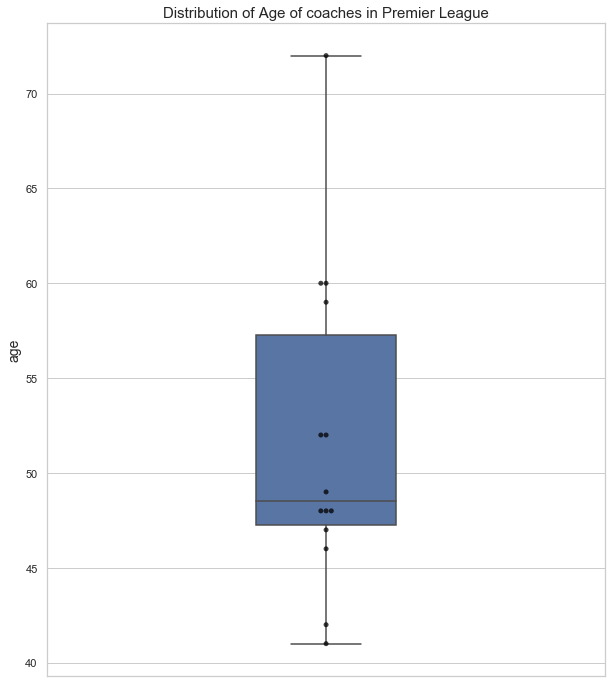

In [49]:
plt.figure(figsize=(10,12))
sns.set(style="whitegrid")
#creating a boxplot using seaborn
ax = sns.boxplot(y = df_age_sorted['age'], width=0.25)
ax.axes.set_title("Distribution of Age of coaches in Premier League",
                    fontsize=15)
ax.set_ylabel("Age", fontsize=14)
#creating a swarmplot using seaborn
bx = sns.swarmplot(y = df_age_sorted['age'],color='black',alpha=0.75)

In [50]:
# output file name
plot_file_name="/users/poojacj/Desktop/adm_hw2/RQ3/age_distribution_boxplot.jpg"
# save as jpeg
ax.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

<h1> RQ4 </h1>
This code is written by Santo Palaia and Pooja Jambaladinni.

In [1]:
#import libraries
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the json files
event = pd.read_json(r'/users/poojacj/Desktop/adm_hw2/events/events_England.json')[['eventId', 'tags', 'playerId','matchId']]
#consider only pass
pass_event_all=event.loc[event['eventId']==8] 

In [3]:
pass_event_all

,eventId,tags,playerId,matchId
0,8,[{'id': 1801}],25413,2499719
1,8,[{'id': 1801}],370224,2499719
2,8,[{'id': 1801}],3319,2499719
3,8,[{'id': 1801}],120339,2499719
4,8,[{'id': 1801}],167145,2499719
...,...,...,...,...
643134,8,[{'id': 1801}],8313,2500098
643135,8,[{'id': 1801}],379209,2500098
643141,8,[{'id': 1801}],8561,2500098
643142,8,[{'id': 1801}],20620,2500098


In [4]:
#drop column eventId
pass_event_all.drop('eventId', axis=1, inplace=True) #we don't need eventId

In [5]:
myList=[]
for index, row in pass_event_all.iterrows():
    myList.append(1) if {'id':1801} in row['tags'] else myList.append(0) #create a list of 1 (pass compleate) and 0 (pass not totaly complete)

In [6]:
pass_event_all['pass']=myList #add this column
pass_event_all.drop('tags', axis=1, inplace=True) #we don't need tags

In [7]:
pass_event_all

,playerId,matchId,pass
0,25413,2499719,1
1,370224,2499719,1
2,3319,2499719,1
3,120339,2499719,1
4,167145,2499719,1
...,...,...,...
643134,8313,2500098,1
643135,379209,2500098,1
643141,8561,2500098,1
643142,20620,2500098,1


In [8]:
#choosing the threshold value for minimum attempted passes by calculating the average passes attempted for a match per player
df_threshold = (pass_event_all.groupby(['playerId', 'matchId'], as_index=False).count()
            .groupby('playerId')['pass'].mean())

In [9]:
threshold_value = df_threshold.mean()

In [10]:
pass_event_final=pass_event_all.groupby('playerId').agg({'pass':['sum', 'count']}) #grouping on playerId and aggregating on sum(number of comlete pass) and count of total pass tried
pass_event_final.columns=['_'.join(col).strip() for col in pass_event_final.columns.values] #redefination of columns
pass_event_final=pass_event_final.reset_index() #reset the index

In [11]:
pass_event_final

,playerId,pass_sum,pass_count
0,0,0,6
1,36,790,898
2,38,192,224
3,48,2113,2370
4,54,1803,2196
...,...,...,...
509,448708,5,6
510,450826,12,17
511,486252,165,226
512,531655,7,11


In [12]:
#filtering out the data on threshold value
pass_event_final = pass_event_final[pass_event_final["pass_count"] > threshold_value]

In [13]:
pass_event_final

,playerId,pass_sum,pass_count
1,36,790,898
2,38,192,224
3,48,2113,2370
4,54,1803,2196
5,56,78,97
...,...,...,...
502,442211,62,81
503,447205,38,43
505,447379,69,84
507,447812,126,171


In [14]:
pass_event_final["ratio"] = pass_event_final["pass_sum"] / pass_event_final["pass_count"]

In [15]:
pass_event_final

,playerId,pass_sum,pass_count,ratio
1,36,790,898,0.879733
2,38,192,224,0.857143
3,48,2113,2370,0.891561
4,54,1803,2196,0.821038
5,56,78,97,0.804124
...,...,...,...,...
502,442211,62,81,0.765432
503,447205,38,43,0.883721
505,447379,69,84,0.821429
507,447812,126,171,0.736842


In [16]:
#sort the columns in descending order of ratio
pass_event_final_sorted = pass_event_final.sort_values(by='ratio', ascending=False)

In [17]:
pass_event_final_sorted.head(15)

,playerId,pass_sum,pass_count,ratio
223,9380,1175,1204,0.975914
142,8324,383,404,0.948020
159,8464,1497,1584,0.945076
137,8307,1312,1391,0.943206
401,135103,1211,1288,0.940217
59,7856,219,233,0.939914
77,7918,992,1057,0.938505
356,70086,2779,2964,0.937584
391,120339,781,834,0.936451
253,14808,1263,1350,0.935556


In [18]:
#select the top 10 rows with maximun value of ratio
df_top_players = pass_event_final_sorted[:10]

In [19]:
df_top_players

,playerId,pass_sum,pass_count,ratio
223,9380,1175,1204,0.975914
142,8324,383,404,0.948020
159,8464,1497,1584,0.945076
137,8307,1312,1391,0.943206
401,135103,1211,1288,0.940217
59,7856,219,233,0.939914
77,7918,992,1057,0.938505
356,70086,2779,2964,0.937584
391,120339,781,834,0.936451
253,14808,1263,1350,0.935556


In [20]:
#select only the player ID and the ratio of passes
df_result = df_top_players[['playerId','ratio']]

In [21]:
#change the names of columns
df_result.columns = ['wyId','RatioPasses']

In [22]:
df_result

,wyId,RatioPasses
223,9380,0.975914
142,8324,0.948020
159,8464,0.945076
137,8307,0.943206
401,135103,0.940217
59,7856,0.939914
77,7918,0.938505
356,70086,0.937584
391,120339,0.936451
253,14808,0.935556


In [23]:
#load the player data into a dataframe
df_player = pd.read_json('/users/poojacj/Desktop/adm_hw2/players.json')[['lastName','wyId']]

In [24]:
df_player

,lastName,wyId
0,Tekin,32777
1,Sarr,393228
2,Mandanda,393230
3,N'Diaye,32793
4,Konat\u00e9,393247
...,...,...
3598,Ma\u00e2loul,120839
3599,C\u00e1ceda Oyaguez,114736
3600,Araujo Blanco,114908
3601,Tagnaouti,285583


In [25]:
#left join the teams and event results dataframes on id to get the names of players
df_merge_col = pd.merge(df_result, df_player, on='wyId', how='left')

In [26]:
df_merge_col

,wyId,RatioPasses,lastName
0,9380,0.975914,Stones
1,8324,0.948020,Tour\u00e9
2,8464,0.945076,Delph
3,8307,0.943206,Kompany
4,135103,0.940217,Christensen
5,7856,0.939914,Mertesacker
6,7918,0.938505,Jones
7,70086,0.937584,Otamendi
8,120339,0.936451,Elsayed Elneny
9,14808,0.935556,G\u00fcndo\u011fan


In [75]:
a = 'Tour\u00e9'
df_merge_col['lastName'][1] = a.encode('utf-8').decode('utf-8')

In [76]:
b = 'G\u00fcndo\u011fan'
df_merge_col['lastName'][9] = b.encode('utf-8').decode('utf-8')

In [77]:
df_merge_col['lastName']

0            Stones
1             Touré
2             Delph
3           Kompany
4       Christensen
5       Mertesacker
6             Jones
7          Otamendi
8    Elsayed Elneny
9          Gündoğan
Name: lastName, dtype: object

In [359]:
#save the results to a csv file
df_merge_col.to_csv("/users/poojacj/Desktop/adm_hw2/RQ4/highest_ratio_of_passes.csv",index=None, encoding='utf-16')

# RQ5

In [1]:
#import libraries
#import pandas as pd
#import seaborn as sns
#import json
#import matplotlib.pyplot as plt
#import numpy as np
#from datetime import datetime
#from bokeh.plotting import figure, output_file, show
#from bokeh.models import ColumnDataSource
#from bokeh.models.tools import HoverTool
#from bokeh.io import output_notebook
#import warnings
warnings.filterwarnings('ignore')

In [2]:
#read json data into pandas datframe
df_events = pd.read_json ('/users/poojacj/Desktop/adm_hw2/events/events_England.json')

In [3]:
df_events

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
643146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
643148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [4]:
#filter the event dataset on subEventName
df_events = df_events[df_events.subEventName == "Air duel"]

In [5]:
df_events.head(10)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",2499719,Duel,1631,1H,14.765321,10,177959189
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",2499719,Duel,1609,1H,14.765321,10,177961218
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",2499719,Duel,1631,1H,21.878309,10,177959191
13,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181
27,1,Air duel,"[{'id': 703}, {'id': 1801}]",192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",2499719,Duel,1631,1H,47.717508,10,177959210
28,1,Air duel,"[{'id': 701}, {'id': 1802}]",7945,"[{'y': 44, 'x': 40}, {'y': 51, 'x': 44}]",2499719,Duel,1609,1H,48.265872,10,177959188
60,1,Air duel,"[{'id': 701}, {'id': 1802}]",8488,"[{'y': 41, 'x': 93}, {'y': 52, 'x': 85}]",2499719,Duel,1631,1H,178.239539,10,177959246
61,1,Air duel,"[{'id': 703}, {'id': 1801}]",120339,"[{'y': 59, 'x': 7}, {'y': 48, 'x': 15}]",2499719,Duel,1609,1H,178.317724,10,177959224
89,1,Air duel,"[{'id': 701}, {'id': 1802}]",49876,"[{'y': 48, 'x': 4}, {'y': 48, 'x': 4}]",2499719,Duel,1609,1H,253.893086,10,177959248
90,1,Air duel,"[{'id': 703}, {'id': 1801}]",14763,"[{'y': 52, 'x': 96}, {'y': 52, 'x': 96}]",2499719,Duel,1631,1H,254.036308,10,177959279


In [6]:
#drop unnecessary columns
df_events = df_events.drop(['positions','matchPeriod','eventSec'], axis = 1)

In [7]:
df_events

,eventId,subEventName,tags,playerId,matchId,eventName,teamId,subEventId,id
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,2499719,Duel,1631,10,177959189
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,2499719,Duel,1609,10,177961218
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,2499719,Duel,1631,10,177959191
13,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,2499719,Duel,1609,10,177959181
27,1,Air duel,"[{'id': 703}, {'id': 1801}]",192748,2499719,Duel,1631,10,177959210
...,...,...,...,...,...,...,...,...,...
642949,1,Air duel,"[{'id': 703}, {'id': 1801}]",37725,2500098,Duel,1633,10,251596054
643053,1,Air duel,"[{'id': 701}, {'id': 1802}]",56,2500098,Duel,1623,10,251596358
643054,1,Air duel,"[{'id': 703}, {'id': 1801}]",8313,2500098,Duel,1633,10,251596102
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,2500098,Duel,1623,10,251596410


In [8]:
#add another column in the dataframe called "AirDuelWon" as 1 if tags = 703 otherwise 0
filtered_data = []
for i,x in df_events['tags'].items():
    for j in x:
        if j['id'] == 703:
            filtered_data.append({'index': i, 'tags': x, 'AirDuelWon': int(1)})
        elif (j['id'] == 701) | (j['id'] == 702) :
            filtered_data.append({'index': i, 'tags': x, 'AirDuelWon': int(0)})

In [9]:
filtered_data = pd.DataFrame(filtered_data)

In [10]:
filtered_data.head(10)

,index,tags,AirDuelWon
0,7,"[{'id': 701}, {'id': 1802}]",0
1,8,"[{'id': 703}, {'id': 1801}]",1
2,12,"[{'id': 703}, {'id': 1801}]",1
3,13,"[{'id': 701}, {'id': 1802}]",0
4,27,"[{'id': 703}, {'id': 1801}]",1
5,28,"[{'id': 701}, {'id': 1802}]",0
6,60,"[{'id': 701}, {'id': 1802}]",0
7,61,"[{'id': 703}, {'id': 1801}]",1
8,89,"[{'id': 701}, {'id': 1802}]",0
9,90,"[{'id': 703}, {'id': 1801}]",1


In [11]:
#setting the index 
filtered_data = filtered_data.set_index('index')

In [12]:
filtered_data.head(10)

,tags,AirDuelWon
index,,
7,"[{'id': 701}, {'id': 1802}]",0
8,"[{'id': 703}, {'id': 1801}]",1
12,"[{'id': 703}, {'id': 1801}]",1
13,"[{'id': 701}, {'id': 1802}]",0
27,"[{'id': 703}, {'id': 1801}]",1
28,"[{'id': 701}, {'id': 1802}]",0
60,"[{'id': 701}, {'id': 1802}]",0
61,"[{'id': 703}, {'id': 1801}]",1
89,"[{'id': 701}, {'id': 1802}]",0


In [13]:
#merge events and filtered dataframes on index
df_events = df_events.merge(filtered_data, left_index=True, right_index=True)

In [14]:
df_events

,eventId,subEventName,tags_x,playerId,matchId,eventName,teamId,subEventId,id,tags_y,AirDuelWon
7,1,Air duel,"[{'id': 701}, {'id': 1802}]",8013,2499719,Duel,1631,10,177959189,"[{'id': 701}, {'id': 1802}]",0
8,1,Air duel,"[{'id': 703}, {'id': 1801}]",0,2499719,Duel,1609,10,177961218,"[{'id': 703}, {'id': 1801}]",1
12,1,Air duel,"[{'id': 703}, {'id': 1801}]",8653,2499719,Duel,1631,10,177959191,"[{'id': 703}, {'id': 1801}]",1
13,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,2499719,Duel,1609,10,177959181,"[{'id': 701}, {'id': 1802}]",0
27,1,Air duel,"[{'id': 703}, {'id': 1801}]",192748,2499719,Duel,1631,10,177959210,"[{'id': 703}, {'id': 1801}]",1
...,...,...,...,...,...,...,...,...,...,...,...
642949,1,Air duel,"[{'id': 703}, {'id': 1801}]",37725,2500098,Duel,1633,10,251596054,"[{'id': 703}, {'id': 1801}]",1
643053,1,Air duel,"[{'id': 701}, {'id': 1802}]",56,2500098,Duel,1623,10,251596358,"[{'id': 701}, {'id': 1802}]",0
643054,1,Air duel,"[{'id': 703}, {'id': 1801}]",8313,2500098,Duel,1633,10,251596102,"[{'id': 703}, {'id': 1801}]",1
643147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,2500098,Duel,1623,10,251596410,"[{'id': 701}, {'id': 1802}]",0


In [15]:
#drop unnecessary columns
df_events = df_events.drop(['eventId','subEventName','tags_x','eventName','subEventId','tags_y'], axis=1)

In [16]:
df_events

,playerId,matchId,teamId,id,AirDuelWon
7,8013,2499719,1631,177959189,0
8,0,2499719,1609,177961218,1
12,8653,2499719,1631,177959191,1
13,25413,2499719,1609,177959181,0
27,192748,2499719,1631,177959210,1
...,...,...,...,...,...
642949,37725,2500098,1633,251596054,1
643053,56,2500098,1623,251596358,0
643054,8313,2500098,1633,251596102,1
643147,7919,2500098,1623,251596410,0


In [17]:
#choosing the threshold value for minimum attempted air duels by calculating the average air duels attempted for a match per player
df_threshold = (df_events.groupby(['playerId', 'matchId'], as_index=False).count()
            .groupby('playerId')['AirDuelWon'].mean())

In [18]:
df_threshold

playerId
0         8.766962
36        4.230769
38        3.800000
48        5.916667
54        2.080000
            ...   
447538    1.000000
447812    5.000000
448708    1.000000
486252    3.000000
531655    1.000000
Name: AirDuelWon, Length: 492, dtype: float64

In [19]:
threshold_value = df_threshold.mean()

In [20]:
df_groupby = df_events.groupby('playerId').agg({'AirDuelWon':['sum', 'count']})

In [21]:
df_groupby.columns = ['_'.join(col).strip() for col in df_groupby.columns.values]

In [22]:
#reset the index
df_result = df_groupby.reset_index() 

In [23]:
df_result

,playerId,AirDuelWon_sum,AirDuelWon_count
0,0,1061,2972
1,36,23,55
2,38,11,19
3,48,137,213
4,54,15,52
...,...,...,...
487,447538,0,1
488,447812,8,15
489,448708,1,1
490,486252,10,21


In [24]:
#filtering out the data on threshold value
df_result = df_result[df_result["AirDuelWon_count"] > threshold_value]

In [25]:
#reset the index
df_result = df_result.reset_index() 

In [26]:
del df_result['index']

In [27]:
#read json data into pandas datframe
df_players = pd.read_json ('/users/poojacj/Desktop/adm_hw2/players.json')[['shortName','wyId','height']]

In [28]:
df_players.head(10)

,shortName,wyId,height
0,H. Tekin,32777,187
1,M. Sarr,393228,182
2,O. Mandanda,393230,176
3,A. N'Diaye,32793,187
4,I. Konat\u00e9,393247,192
5,J. Cillessen,33,185
6,T. Alderweireld,36,187
7,J. Vertonghen,48,189
8,A. Djiku,229427,182
9,C. Eriksen,54,180


In [29]:
#rename columns to match the playerId in events dataset to wyId in players dataset
df_players.columns = ['PlayerName','playerId','height']

In [30]:
#left join the events and players datasets
df_merge_col = pd.merge(df_result, df_players, on='playerId', how='left')

In [31]:
df_merge_col.head(10)

,playerId,AirDuelWon_sum,AirDuelWon_count,PlayerName,height
0,0,1061,2972,NaN,NaN
1,36,23,55,T. Alderweireld,187.0
2,38,11,19,D. Blind,180.0
3,48,137,213,J. Vertonghen,189.0
4,54,15,52,C. Eriksen,180.0
5,56,3,8,D. Klaassen,179.0
6,74,48,109,R. Klavan,187.0
7,93,42,100,J. Gu\u00f0munds\u00adson,186.0
8,107,58,113,E. Pieters,182.0
9,116,21,54,G. Wijnaldum,175.0


In [32]:
#rename the cloumns
df_merge_col.columns = ['PlayerId','AirDuelsWon','AirDuelsAttempted','PlayerName','Height(in cm)']

In [33]:
df_merge_col.isna().sum()

PlayerId             0
AirDuelsWon          0
AirDuelsAttempted    0
PlayerName           1
Height(in cm)        1
dtype: int64

In [34]:
#drop the rows with empty player name and height
df_final = df_merge_col.dropna(axis = 0, how ='any')

In [35]:
df_final

,PlayerId,AirDuelsWon,AirDuelsAttempted,PlayerName,Height(in cm)
1,36,23,55,T. Alderweireld,187.0
2,38,11,19,D. Blind,180.0
3,48,137,213,J. Vertonghen,189.0
4,54,15,52,C. Eriksen,180.0
5,56,3,8,D. Klaassen,179.0
...,...,...,...,...,...
448,434159,11,21,S. Field,185.0
449,442211,20,40,A. Sabiri,183.0
450,447379,1,6,B. Baningime,178.0
451,447812,8,15,T. Edwards,175.0


In [36]:
df_final["ratio"] = df_final["AirDuelsWon"] / df_final["AirDuelsAttempted"]

In [37]:
#sort the columns in descending order of ratio
df_final = df_final.sort_values(by='ratio', ascending=False)

In [38]:
df_final

,PlayerId,AirDuelsWon,AirDuelsAttempted,PlayerName,Height(in cm),ratio
354,104851,5,5,M. D\u00fabravka,191.0,1.000000
274,25662,6,6,D. Ospina,183.0,1.000000
146,8425,14,14,W. Hennessey,198.0,1.000000
179,8826,10,10,K. Darlow,185.0,1.000000
218,10131,26,27,J. Pickford,185.0,0.962963
...,...,...,...,...,...,...
27,3319,0,17,M. \u00d6zil,180.0,0.000000
127,8296,0,21,J. Defoe,171.0,0.000000
29,3326,0,11,Jes\u00e9 Rodr\u00edguez,178.0,0.000000
31,3348,0,7,Deulofeu,177.0,0.000000


In [39]:
#creating buckets based on the height
bins = [160, 170, 180, 190, 200, 210]
labels =[1,2,3,4,5]
labels_cm = ["160-170","170-180","180-190","190-200","200-210"]
df_final['binned'] = pd.cut(df_final['Height(in cm)'], bins,labels=labels)
df_final['bins'] = pd.cut(df_final['Height(in cm)'],bins,labels=labels_cm )
print (df_final)

     PlayerId  AirDuelsWon  AirDuelsAttempted                PlayerName  \
354    104851            5                  5          M. D\u00fabravka   
274     25662            6                  6                 D. Ospina   
146      8425           14                 14              W. Hennessey   
179      8826           10                 10                 K. Darlow   
218     10131           26                 27               J. Pickford   
..        ...          ...                ...                       ...   
27       3319            0                 17              M. \u00d6zil   
127      8296            0                 21                  J. Defoe   
29       3326            0                 11  Jes\u00e9 Rodr\u00edguez   
31       3348            0                  7                  Deulofeu   
107      8140            0                  7                A. Lallana   

     Height(in cm)     ratio binned     bins  
354          191.0  1.000000      4  190-200  
274  

In [40]:
# name the output file of the scatterplot
# output_file('RQ5_scatterplot.html')
output_notebook()

Loading BokehJS ...

In [41]:
#creating another column with the colour mapped for each bucket
colormap = {1: '#fff9bd',
            2: '#a9cdff',
            3: '#70c7c1',
            4: '#f08c8c',
            5: '#f0c7ff'}
# colors = [colormap[x] for x in df_final['binned']]
df_final['color'] = df_final['binned'].map(lambda x: colormap[x])

In [42]:
df_final['color']

354    #f08c8c
274    #70c7c1
146    #f08c8c
179    #70c7c1
218    #70c7c1
        ...   
27     #a9cdff
127    #a9cdff
29     #a9cdff
31     #a9cdff
107    #a9cdff
Name: color, Length: 452, dtype: category
Categories (5, object): [#fff9bd < #a9cdff < #70c7c1 < #f08c8c < #f0c7ff]

In [43]:
df_final

,PlayerId,AirDuelsWon,AirDuelsAttempted,PlayerName,Height(in cm),ratio,binned,bins,color
354,104851,5,5,M. D\u00fabravka,191.0,1.000000,4,190-200,#f08c8c
274,25662,6,6,D. Ospina,183.0,1.000000,3,180-190,#70c7c1
146,8425,14,14,W. Hennessey,198.0,1.000000,4,190-200,#f08c8c
179,8826,10,10,K. Darlow,185.0,1.000000,3,180-190,#70c7c1
218,10131,26,27,J. Pickford,185.0,0.962963,3,180-190,#70c7c1
...,...,...,...,...,...,...,...,...,...
27,3319,0,17,M. \u00d6zil,180.0,0.000000,2,170-180,#a9cdff
127,8296,0,21,J. Defoe,171.0,0.000000,2,170-180,#a9cdff
29,3326,0,11,Jes\u00e9 Rodr\u00edguez,178.0,0.000000,2,170-180,#a9cdff
31,3348,0,7,Deulofeu,177.0,0.000000,2,170-180,#a9cdff


In [44]:
#take the resultant dataframe as samples based on bins
sample1 = df_final[df_final["binned"] == 1]
source1 = ColumnDataSource(sample1)
sample2 = df_final[df_final["binned"] == 2]
source2 = ColumnDataSource(sample2)
sample3 = df_final[df_final["binned"] == 3]
source3 = ColumnDataSource(sample3)
sample4 = df_final[df_final["binned"] == 4]
source4 = ColumnDataSource(sample4)
sample5 = df_final[df_final["binned"] == 5]
source5 = ColumnDataSource(sample5)

In [45]:
#plot the scatterplot marking the legend
p = figure(plot_width=980, plot_height=600,background_fill_color='black')
p.circle(x="Height(in cm)", y="ratio",
         source=source1,
         size=5, color = "color", legend = "160cm - 170cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source2,
         size=5, color = "color", legend = "170cm - 180cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source3,
         size=5, color = "color", legend = "180cm - 190cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source4,
         size=5, color = "color", legend = "190cm - 200cm")
p.circle(x="Height(in cm)", y="ratio",
         source=source5,
         size=5, color = "color", legend = "200cm - 210cm" )

# change just some things about the x-grid
p.xgrid.grid_line_color = "#636363"
# change just some things about the y-grid
p.ygrid.grid_line_color = "#636363"
p.legend.location = "bottom_right"
p.legend.border_line_width = 3
p.legend.border_line_color = "black"
p.legend.border_line_alpha = 0.5

In [46]:
#set the title and x and y labels
p.title.text = "Distribution of height and air duels for each player in the English Premier league"
p.xaxis.axis_label = "Height (in cm)"
p.yaxis.axis_label = "Ratio of air duels won to air duels attempted"

In [47]:
#show player name on hover
hover = HoverTool()
hover.tooltips=[
    ('Player Name', '@PlayerName')
]
p.add_tools(hover)
show(p)

# CRQ1

In [2]:
import pandas as pd
import matplotlib.pyplot as mpl
import numpy as np

event = pd.read_json(r'/home/tiago/Scrivania/Libri Magistrale/1st semester/ADM/HomeWork2/Event/events_England.json')[ ['playerId', 'tags','matchId', 'teamId', 'matchPeriod', 'eventSec']]
event.head(100)

,playerId,tags,matchId,teamId,matchPeriod,eventSec
0,25413,[{'id': 1801}],2499719,1609,1H,2.758649
1,370224,[{'id': 1801}],2499719,1609,1H,4.946850
2,3319,[{'id': 1801}],2499719,1609,1H,6.542188
3,120339,[{'id': 1801}],2499719,1609,1H,8.143395
4,167145,[{'id': 1801}],2499719,1609,1H,10.302366
...,...,...,...,...,...,...
95,8480,[],2499719,1631,1H,324.623007
96,8480,[{'id': 1801}],2499719,1631,1H,340.684982
97,14853,[{'id': 1801}],2499719,1631,1H,342.852928
98,370224,"[{'id': 703}, {'id': 1801}]",2499719,1609,1H,344.968625


In [3]:
myRow=[] #looking for goals
for index, row in event.iterrows():
    tags=row['tags']
    for e in tags:
        if e == {'id':101}:
            myRow.append(row)
event=pd.DataFrame(myRow) #create a dataframe with only goals
event.drop('tags', axis=1, inplace=True) #remove tags

#event=event['id' in event['tags'].keys() and 101 in event['tags'].values()]
event.head()

,playerId,matchId,teamId,matchPeriod,eventSec
46,25413,2499719,1609,1H,94.595788
47,8480,2499719,1631,1H,96.970614
91,14763,2499719,1631,1H,254.745027
92,7882,2499719,1609,1H,256.547834
554,12829,2499719,1631,1H,1710.855093


In [4]:
secOf9min=60*9

event['eventSecDiscrete']=event['eventSec']/secOf9min #create the seconds decrete
event['eventSecDiscrete']=event['eventSecDiscrete'].astype(int) #arount to int
event.drop('eventSec', axis=1, inplace=True) 
event.head()

,playerId,matchId,teamId,matchPeriod,eventSecDiscrete
46,25413,2499719,1609,1H,0
47,8480,2499719,1631,1H,0
91,14763,2499719,1631,1H,0
92,7882,2499719,1609,1H,0
554,12829,2499719,1631,1H,3


# i. Make a barplot with the absolute frequency of goals in all the time slots.

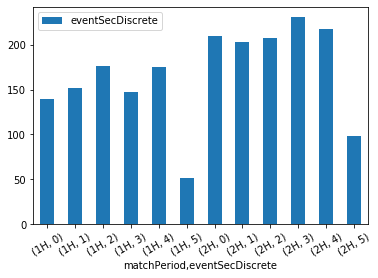

In [6]:
eventGroupSecDiscrete=event.groupby(['matchPeriod', 'eventSecDiscrete']).agg({'eventSecDiscrete':'count'}) #groping on periods and second descrete counting the second discrete
ax=eventGroupSecDiscrete.plot.bar(rot=30)

# ii. Find the top 10 teams that score the most in the interval "81-90"

In [7]:
#filter event by the minutes 81-90 -> (2H, 4) 
event2H4=event.loc[(event['matchPeriod']=='2H') & (event['eventSecDiscrete']==4)]#selection

eventGroupTeams=event2H4.groupby('teamId').agg({'eventSecDiscrete':'count'}) #grouping on teamId and aggregating counting on seconds dicrete


print(eventGroupTeams, end='\n\n')
gt=eventGroupTeams.to_dict()['eventSecDiscrete'] #trasform the dataframe into a ictionary and optain the inside dictionary
print('First 10 team by number of goals')
for w in sorted(gt, key=gt.get, reverse=True)[:10]:#print the first ten sorted elements
  print(w, gt[w])

        eventSecDiscrete
teamId                  
1609                  16
1610                  13
1611                  10
1612                  11
1613                   7
1619                   8
1623                  12
1624                   9
1625                  15
1627                   8
1628                  13
1631                   9
1633                  15
1639                  11
1644                  16
1646                   7
1651                  10
1659                  11
1673                   4
10531                 12

First 10 team by number of goals
1609 16
1644 16
1625 15
1633 15
1610 13
1628 13
1623 12
10531 12
1612 11
1639 11


# iii. Show if there are players that were able to score at least one goal in 8 different intervals

In [24]:
eventWitoutDuplicateOnId_eventSecDiscrete=event.drop_duplicates(['playerId', 'matchPeriod', 'eventSecDiscrete'])
#print(eventWitoutDuplicateOnId_eventSecDiscrete)
eventPlayerGoal=eventWitoutDuplicateOnId_eventSecDiscrete.groupby('playerId').agg({'eventSecDiscrete':'count'})
#eventPlayer8=eventPlayerGoal.loc[eventPlayerGoal[]]
#print(eventPlayerGoal)
eventPlayerGoalDict=eventPlayerGoal['eventSecDiscrete'].to_dict()

#print('Player with at least one goal in 8 different intervals')
for w in eventPlayerGoalDict.keys():#print the first ten sorted elements
    if eventPlayerGoalDict[w]>=8:
        print(w, eventPlayerGoalDict[w])

3324 9
3429 11
3582 11
7847 11
7882 11
7905 9
7910 11
7974 10
8094 11
8266 11
8301 12
8358 12
8391 10
8422 8
8425 11
8480 12
8514 11
8580 10
8717 11
8726 12
10131 11
11066 11
12242 11
12829 11
14703 8
15175 9
15808 8
25381 12
25413 8
26150 9
56038 12
61390 12
61941 10
71654 12
92864 9
120353 11
340386 9


# CRQ2

<h1> CR2 (part1) </h1>

In [1]:
#import libraries
#import json
#from pandas.io.json import json_normalize
#import matplotlib.pyplot as plt
#import seaborn as sns
#import matplotlib.patches as patches
#import pandas as pd

In [2]:
#load the Spain events json data into pandas dataframe
with open('/users/poojacj/Desktop/adm_hw2/events/events_Spain.json') as data_file:    
    data = json.load(data_file)
df_events = json_normalize(data, sep = "_")

In [3]:
df_events.head(10)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
5,8,Simple pass,[{'id': 1801}],3277,"[{'y': 37, 'x': 31}, {'y': 83, 'x': 37}]",2565548,Pass,682,1H,18.480831,85,180864423
6,8,Simple pass,[{'id': 1801}],3695,"[{'y': 83, 'x': 37}, {'y': 53, 'x': 13}]",2565548,Pass,682,1H,23.978291,85,180864424
7,8,Simple pass,[{'id': 1801}],3486,"[{'y': 53, 'x': 13}, {'y': 41, 'x': 33}]",2565548,Pass,682,1H,28.831334,85,180864425
8,8,Simple pass,[{'id': 1801}],3277,"[{'y': 41, 'x': 33}, {'y': 79, 'x': 33}]",2565548,Pass,682,1H,30.844379,85,180864426
9,8,Simple pass,[{'id': 1801}],3695,"[{'y': 79, 'x': 33}, {'y': 98, 'x': 54}]",2565548,Pass,682,1H,34.267339,85,180864427


In [4]:
#loading the Spain matches data into pandas dataframe
with open('/users/poojacj/Desktop/adm_hw2/matches/matches_Spain.json') as data_file:    
    data = json.load(data_file)
df_matches = json_normalize(data, sep = "_")

In [5]:
#checking for Barcelona - Real Madrid game played on 5th May,2018
df_matches[df_matches["label"].str.contains("Barcelona - Real Madrid")]

,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId,label,date,...,teamsData_695_coachId,teamsData_695_side,teamsData_695_teamId,teamsData_695_score,teamsData_695_scoreP,teamsData_695_hasFormation,teamsData_695_formation_bench,teamsData_695_formation_lineup,teamsData_695_formation_substitutions,teamsData_695_scoreHT
23,Played,4406122,36,181144,2018-05-06 18:45:00,0,Camp Nou,2565907,"Barcelona - Real Madrid, 2 - 2","May 6, 2018 at 8:45:00 PM GMT+2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#matching the wyId of matches data to matchId of events data to get the appropriate data
df_events  = df_events[df_events["matchId"] == 2565907]

In [7]:
#considering only passes,shoots,duels and freekicks
df_events = df_events[(df_events["eventId"] == 8) | (df_events["eventId"] == 3) | (df_events["eventId"] == 1) | (df_events["eventId"] == 10)]

In [8]:
#load the json player dataset into pandas dataframe
with open('/users/poojacj/Desktop/adm_hw2/players.json') as data_file:    
    data = json.load(data_file)
df_player = json_normalize(data, sep = "_")

In [9]:
#checking the wyId of Cristiano Ronaldo
df_player[df_player["firstName"] == "Cristiano Ronaldo"]

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea_id,passportArea_alpha3code,passportArea_alpha2code,role_code2,role_code3,role_name,birthArea_name,birthArea_id,birthArea_alpha3code,birthArea_alpha2code
185,83,Cristiano Ronaldo,,dos Santos Aveiro,3159,1985-02-05,187,3322,right,Cristiano Ronaldo,...,620,PRT,PT,FW,FWD,Forward,Portugal,620,PRT,PT


In [10]:
#checking the wyId of Lionel Messi
df_player[df_player["lastName"].str.match("Messi")]

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea_id,passportArea_alpha3code,passportArea_alpha2code,role_code2,role_code3,role_name,birthArea_name,birthArea_id,birthArea_alpha3code,birthArea_alpha2code
207,72,Lionel Andr\u00e9s,,Messi Cuccittini,676,1987-06-24,170,3359,left,L. Messi,...,724,ESP,ES,FW,FWD,Forward,Argentina,32,ARG,AR


In [11]:
#considering only the events by Cristiano Ronaldo
df_events_ronaldo = df_events[df_events["playerId"] == 3322]

In [12]:
#considering only the events by Lionel Messi
df_events_messi = df_events[df_events["playerId"] == 3359]

In [13]:
df_events_ronaldo

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
593473,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",3322,"[{'y': 19, 'x': 49}, {'y': 17, 'x': 49}]",2565907,Duel,675,1H,68.618689,13,249644112
593475,1,Air duel,"[{'id': 701}, {'id': 1802}]",3322,"[{'y': 17, 'x': 49}, {'y': 19, 'x': 38}]",2565907,Duel,675,1H,69.411334,10,249644113
593497,1,Ground defending duel,"[{'id': 701}, {'id': 1802}]",3322,"[{'y': 13, 'x': 65}, {'y': 23, 'x': 53}]",2565907,Duel,675,1H,114.548692,12,249644119
593552,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",3322,"[{'y': 12, 'x': 93}, {'y': 8, 'x': 97}]",2565907,Duel,675,1H,275.327960,11,249644145
593554,8,Cross,"[{'id': 401}, {'id': 801}, {'id': 1802}]",3322,"[{'y': 8, 'x': 97}, {'y': 100, 'x': 100}]",2565907,Pass,675,1H,277.578035,80,249644146
593600,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",3322,"[{'y': 57, 'x': 46}, {'y': 36, 'x': 42}]",2565907,Duel,675,1H,403.870069,11,249644178
593601,8,Simple pass,[{'id': 1801}],3322,"[{'y': 36, 'x': 42}, {'y': 28, 'x': 42}]",2565907,Pass,675,1H,406.937034,85,249644179
593605,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",3322,"[{'y': 14, 'x': 91}, {'y': 14, 'x': 88}]",2565907,Duel,675,1H,418.749555,11,249644184
593607,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...",3322,"[{'y': 14, 'x': 88}, {'y': 100, 'x': 100}]",2565907,Shot,675,1H,419.789814,100,249644185
593628,1,Air duel,"[{'id': 701}, {'id': 1802}]",3322,"[{'y': 51, 'x': 93}, {'y': 31, 'x': 90}]",2565907,Duel,675,1H,476.363494,10,249644199


In [14]:
df_events_messi

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
593485,8,Simple pass,[{'id': 1801}],3359,"[{'y': 87, 'x': 74}, {'y': 91, 'x': 80}]",2565907,Pass,676,1H,85.701277,85,249644574
593489,8,Simple pass,[{'id': 1801}],3359,"[{'y': 87, 'x': 67}, {'y': 71, 'x': 43}]",2565907,Pass,676,1H,92.114223,85,249644578
593499,8,Simple pass,[{'id': 1801}],3359,"[{'y': 66, 'x': 58}, {'y': 78, 'x': 75}]",2565907,Pass,676,1H,117.241765,85,249644587
593501,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",3359,"[{'y': 67, 'x': 65}, {'y': 38, 'x': 63}]",2565907,Duel,676,1H,122.168204,11,249644589
593503,8,Simple pass,[{'id': 1801}],3359,"[{'y': 38, 'x': 63}, {'y': 43, 'x': 69}]",2565907,Pass,676,1H,124.686582,85,249644590
...,...,...,...,...,...,...,...,...,...,...,...,...
595053,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",3359,"[{'y': 76, 'x': 84}, {'y': 72, 'x': 96}]",2565907,Duel,676,2H,2197.469246,11,249646165
595055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",3359,"[{'y': 72, 'x': 96}, {'y': 0, 'x': 0}]",2565907,Shot,676,2H,2199.766741,100,249646166
595106,1,Ground attacking duel,"[{'id': 602}, {'id': 702}, {'id': 1801}]",3359,"[{'y': 83, 'x': 44}, {'y': 93, 'x': 36}]",2565907,Duel,676,2H,2411.569686,11,249646184
595131,8,Launch,[{'id': 1802}],3359,"[{'y': 8, 'x': 44}, {'y': 42, 'x': 63}]",2565907,Pass,676,2H,2558.961654,84,249646196


In [15]:
#separating out the position values for Ronaldo
filtered_data_start_pos = []
filtered_data_end_pos = []
for i,x in df_events_ronaldo['positions'].items():
    filtered_data_start_pos.append({'index': i, 'start_pos': x[0]})
    filtered_data_end_pos.append({'index': i, 'start_pos': x[1]})   

In [16]:
filtered_data_start_pos = pd.DataFrame(filtered_data_start_pos)
filtered_data_end_pos = pd.DataFrame(filtered_data_end_pos)

In [17]:
#setting the index 
filtered_data_start_pos = filtered_data_start_pos.set_index('index')
filtered_data_end_pos = filtered_data_end_pos.set_index('index') 

In [18]:
#merge events and filtered position dataframes on index
df_events_ronaldo = df_events_ronaldo.merge(filtered_data_start_pos, left_index=True, right_index=True)

In [19]:
#merge events and filtered position dataframes on index
df_events_ronaldo = df_events_ronaldo.merge(filtered_data_end_pos, left_index=True, right_index=True)

In [20]:
df_events_ronaldo.drop(['eventId','subEventName','tags','matchPeriod','eventSec','subEventId'], axis=1, inplace=True)

In [21]:
df_events_ronaldo

,playerId,positions,matchId,eventName,teamId,id,start_pos_x,start_pos_y
593473,3322,"[{'y': 19, 'x': 49}, {'y': 17, 'x': 49}]",2565907,Duel,675,249644112,"{'y': 19, 'x': 49}","{'y': 17, 'x': 49}"
593475,3322,"[{'y': 17, 'x': 49}, {'y': 19, 'x': 38}]",2565907,Duel,675,249644113,"{'y': 17, 'x': 49}","{'y': 19, 'x': 38}"
593497,3322,"[{'y': 13, 'x': 65}, {'y': 23, 'x': 53}]",2565907,Duel,675,249644119,"{'y': 13, 'x': 65}","{'y': 23, 'x': 53}"
593552,3322,"[{'y': 12, 'x': 93}, {'y': 8, 'x': 97}]",2565907,Duel,675,249644145,"{'y': 12, 'x': 93}","{'y': 8, 'x': 97}"
593554,3322,"[{'y': 8, 'x': 97}, {'y': 100, 'x': 100}]",2565907,Pass,675,249644146,"{'y': 8, 'x': 97}","{'y': 100, 'x': 100}"
593600,3322,"[{'y': 57, 'x': 46}, {'y': 36, 'x': 42}]",2565907,Duel,675,249644178,"{'y': 57, 'x': 46}","{'y': 36, 'x': 42}"
593601,3322,"[{'y': 36, 'x': 42}, {'y': 28, 'x': 42}]",2565907,Pass,675,249644179,"{'y': 36, 'x': 42}","{'y': 28, 'x': 42}"
593605,3322,"[{'y': 14, 'x': 91}, {'y': 14, 'x': 88}]",2565907,Duel,675,249644184,"{'y': 14, 'x': 91}","{'y': 14, 'x': 88}"
593607,3322,"[{'y': 14, 'x': 88}, {'y': 100, 'x': 100}]",2565907,Shot,675,249644185,"{'y': 14, 'x': 88}","{'y': 100, 'x': 100}"
593628,3322,"[{'y': 51, 'x': 93}, {'y': 31, 'x': 90}]",2565907,Duel,675,249644199,"{'y': 51, 'x': 93}","{'y': 31, 'x': 90}"


In [22]:
#rename the column names
df_events_ronaldo.columns = ['playerId','positions','matchId','eventName','teamId','id','start_position','end_position']

In [23]:
#rescaling the x and y coordinates
x_y_pos_start = []
for i,j in df_events_ronaldo["start_position"].items():
    x_y_pos_start.append({'index': i, 'start_pos': [j['x']*1.2,j['y']*0.8]})

In [24]:
start_pos = pd.DataFrame(x_y_pos_start)

In [25]:
start_pos 

,index,start_pos
0,593473,"[58.8, 15.200000000000001]"
1,593475,"[58.8, 13.600000000000001]"
2,593497,"[78.0, 10.4]"
3,593552,"[111.6, 9.600000000000001]"
4,593554,"[116.39999999999999, 6.4]"
5,593600,"[55.199999999999996, 45.6]"
6,593601,"[50.4, 28.8]"
7,593605,"[109.2, 11.200000000000001]"
8,593607,"[105.6, 11.200000000000001]"
9,593628,"[111.6, 40.800000000000004]"


In [26]:
#setting the index 
start_pos = start_pos.set_index('index')

In [27]:
#merge teams and filtered dataframes on index
df_events_ronaldo = df_events_ronaldo.merge(start_pos, left_index=True, right_index=True)

In [28]:
df_events_ronaldo

,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos
593473,3322,"[{'y': 19, 'x': 49}, {'y': 17, 'x': 49}]",2565907,Duel,675,249644112,"{'y': 19, 'x': 49}","{'y': 17, 'x': 49}","[58.8, 15.200000000000001]"
593475,3322,"[{'y': 17, 'x': 49}, {'y': 19, 'x': 38}]",2565907,Duel,675,249644113,"{'y': 17, 'x': 49}","{'y': 19, 'x': 38}","[58.8, 13.600000000000001]"
593497,3322,"[{'y': 13, 'x': 65}, {'y': 23, 'x': 53}]",2565907,Duel,675,249644119,"{'y': 13, 'x': 65}","{'y': 23, 'x': 53}","[78.0, 10.4]"
593552,3322,"[{'y': 12, 'x': 93}, {'y': 8, 'x': 97}]",2565907,Duel,675,249644145,"{'y': 12, 'x': 93}","{'y': 8, 'x': 97}","[111.6, 9.600000000000001]"
593554,3322,"[{'y': 8, 'x': 97}, {'y': 100, 'x': 100}]",2565907,Pass,675,249644146,"{'y': 8, 'x': 97}","{'y': 100, 'x': 100}","[116.39999999999999, 6.4]"
593600,3322,"[{'y': 57, 'x': 46}, {'y': 36, 'x': 42}]",2565907,Duel,675,249644178,"{'y': 57, 'x': 46}","{'y': 36, 'x': 42}","[55.199999999999996, 45.6]"
593601,3322,"[{'y': 36, 'x': 42}, {'y': 28, 'x': 42}]",2565907,Pass,675,249644179,"{'y': 36, 'x': 42}","{'y': 28, 'x': 42}","[50.4, 28.8]"
593605,3322,"[{'y': 14, 'x': 91}, {'y': 14, 'x': 88}]",2565907,Duel,675,249644184,"{'y': 14, 'x': 91}","{'y': 14, 'x': 88}","[109.2, 11.200000000000001]"
593607,3322,"[{'y': 14, 'x': 88}, {'y': 100, 'x': 100}]",2565907,Shot,675,249644185,"{'y': 14, 'x': 88}","{'y': 100, 'x': 100}","[105.6, 11.200000000000001]"
593628,3322,"[{'y': 51, 'x': 93}, {'y': 31, 'x': 90}]",2565907,Duel,675,249644199,"{'y': 51, 'x': 93}","{'y': 31, 'x': 90}","[111.6, 40.800000000000004]"


In [29]:
#rescaling the x and y coordinates
x_y_pos_end = []
for i,j in df_events_ronaldo["end_position"].items():
    x_y_pos_end.append({'index': i, 'end_pos': [j['x']*1.2,j['y']*0.8]})

In [30]:
end_pos = pd.DataFrame(x_y_pos_end)

In [31]:
end_pos

,index,end_pos
0,593473,"[58.8, 13.600000000000001]"
1,593475,"[45.6, 15.200000000000001]"
2,593497,"[63.599999999999994, 18.400000000000002]"
3,593552,"[116.39999999999999, 6.4]"
4,593554,"[120.0, 80.0]"
5,593600,"[50.4, 28.8]"
6,593601,"[50.4, 22.400000000000002]"
7,593605,"[105.6, 11.200000000000001]"
8,593607,"[120.0, 80.0]"
9,593628,"[108.0, 24.8]"


In [32]:
#setting the index 
end_pos = end_pos.set_index('index')

In [33]:
#merge teams and filtered dataframes on index
df_events_ronaldo = df_events_ronaldo.merge(end_pos, left_index=True, right_index=True)

In [34]:
df_events_ronaldo

,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos,end_pos
593473,3322,"[{'y': 19, 'x': 49}, {'y': 17, 'x': 49}]",2565907,Duel,675,249644112,"{'y': 19, 'x': 49}","{'y': 17, 'x': 49}","[58.8, 15.200000000000001]","[58.8, 13.600000000000001]"
593475,3322,"[{'y': 17, 'x': 49}, {'y': 19, 'x': 38}]",2565907,Duel,675,249644113,"{'y': 17, 'x': 49}","{'y': 19, 'x': 38}","[58.8, 13.600000000000001]","[45.6, 15.200000000000001]"
593497,3322,"[{'y': 13, 'x': 65}, {'y': 23, 'x': 53}]",2565907,Duel,675,249644119,"{'y': 13, 'x': 65}","{'y': 23, 'x': 53}","[78.0, 10.4]","[63.599999999999994, 18.400000000000002]"
593552,3322,"[{'y': 12, 'x': 93}, {'y': 8, 'x': 97}]",2565907,Duel,675,249644145,"{'y': 12, 'x': 93}","{'y': 8, 'x': 97}","[111.6, 9.600000000000001]","[116.39999999999999, 6.4]"
593554,3322,"[{'y': 8, 'x': 97}, {'y': 100, 'x': 100}]",2565907,Pass,675,249644146,"{'y': 8, 'x': 97}","{'y': 100, 'x': 100}","[116.39999999999999, 6.4]","[120.0, 80.0]"
593600,3322,"[{'y': 57, 'x': 46}, {'y': 36, 'x': 42}]",2565907,Duel,675,249644178,"{'y': 57, 'x': 46}","{'y': 36, 'x': 42}","[55.199999999999996, 45.6]","[50.4, 28.8]"
593601,3322,"[{'y': 36, 'x': 42}, {'y': 28, 'x': 42}]",2565907,Pass,675,249644179,"{'y': 36, 'x': 42}","{'y': 28, 'x': 42}","[50.4, 28.8]","[50.4, 22.400000000000002]"
593605,3322,"[{'y': 14, 'x': 91}, {'y': 14, 'x': 88}]",2565907,Duel,675,249644184,"{'y': 14, 'x': 91}","{'y': 14, 'x': 88}","[109.2, 11.200000000000001]","[105.6, 11.200000000000001]"
593607,3322,"[{'y': 14, 'x': 88}, {'y': 100, 'x': 100}]",2565907,Shot,675,249644185,"{'y': 14, 'x': 88}","{'y': 100, 'x': 100}","[105.6, 11.200000000000001]","[120.0, 80.0]"
593628,3322,"[{'y': 51, 'x': 93}, {'y': 31, 'x': 90}]",2565907,Duel,675,249644199,"{'y': 51, 'x': 93}","{'y': 31, 'x': 90}","[111.6, 40.800000000000004]","[108.0, 24.8]"


In [35]:
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = patches.Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = patches.Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = patches.Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = patches.ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = patches.Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = patches.Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = patches.Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = patches.Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

<h1> Zones in the heatmap where Critiano Ronaldo was more active </h1>

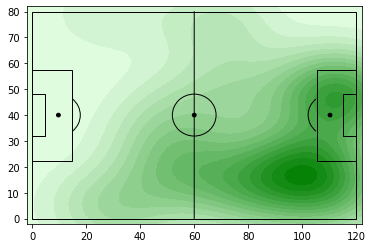

In [36]:
# fig=plt.figure() #set up the figures
# fig.set_size_inches(7, 5)
# ax=fig.add_subplot(1,1,1)

fig, ax = plt.subplots()

x_coord = [i[0] for i in df_events_ronaldo["start_pos"]]
y_coord = [i[1] for i in df_events_ronaldo["start_pos"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 16)

draw_pitch(ax) #overlay our different objects on the pitch

plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('on')
plt.show()

<h4> Cristiano Ronaldo's heatmap for the match Barcelona vs Real Madrid played on the 6 May,2018 clearly shows that he is a right wing attacking player who runs up and down his side of the pitch. He is not a defending player as there
is no movement recorded in the defensive positions. However, there is movement recorded in the penalty box of the opposition which indicates his central attacking ability. Also, the heatmap suggests that he fulfils the role of a striker. 
</h4>

In [38]:
 #separating out the position values for Messi
filtered_data_start_pos_messi = []
filtered_data_end_pos_messi = []
for i,x in df_events_messi['positions'].items():
    filtered_data_start_pos_messi.append({'index': i, 'start_pos': x[0]})
    filtered_data_end_pos_messi.append({'index': i, 'start_pos': x[1]})  

In [39]:
filtered_data_start_pos_messi = pd.DataFrame(filtered_data_start_pos_messi)
filtered_data_end_pos_messi = pd.DataFrame(filtered_data_end_pos_messi)

In [40]:
#setting the index 
filtered_data_start_pos_messi = filtered_data_start_pos_messi.set_index('index')
filtered_data_end_pos_messi = filtered_data_end_pos_messi.set_index('index') 

In [41]:
#merge events and filtered position dataframes on index
df_events_messi = df_events_messi.merge(filtered_data_start_pos_messi, left_index=True, right_index=True)

In [42]:
#merge events and filtered position dataframes on index
df_events_messi = df_events_messi.merge(filtered_data_end_pos_messi, left_index=True, right_index=True)

In [43]:
df_events_messi.drop(['eventId','subEventName','tags','matchPeriod','eventSec','subEventId'], axis=1, inplace=True)

In [44]:
df_events_messi

,playerId,positions,matchId,eventName,teamId,id,start_pos_x,start_pos_y
593485,3359,"[{'y': 87, 'x': 74}, {'y': 91, 'x': 80}]",2565907,Pass,676,249644574,"{'y': 87, 'x': 74}","{'y': 91, 'x': 80}"
593489,3359,"[{'y': 87, 'x': 67}, {'y': 71, 'x': 43}]",2565907,Pass,676,249644578,"{'y': 87, 'x': 67}","{'y': 71, 'x': 43}"
593499,3359,"[{'y': 66, 'x': 58}, {'y': 78, 'x': 75}]",2565907,Pass,676,249644587,"{'y': 66, 'x': 58}","{'y': 78, 'x': 75}"
593501,3359,"[{'y': 67, 'x': 65}, {'y': 38, 'x': 63}]",2565907,Duel,676,249644589,"{'y': 67, 'x': 65}","{'y': 38, 'x': 63}"
593503,3359,"[{'y': 38, 'x': 63}, {'y': 43, 'x': 69}]",2565907,Pass,676,249644590,"{'y': 38, 'x': 63}","{'y': 43, 'x': 69}"
...,...,...,...,...,...,...,...,...
595053,3359,"[{'y': 76, 'x': 84}, {'y': 72, 'x': 96}]",2565907,Duel,676,249646165,"{'y': 76, 'x': 84}","{'y': 72, 'x': 96}"
595055,3359,"[{'y': 72, 'x': 96}, {'y': 0, 'x': 0}]",2565907,Shot,676,249646166,"{'y': 72, 'x': 96}","{'y': 0, 'x': 0}"
595106,3359,"[{'y': 83, 'x': 44}, {'y': 93, 'x': 36}]",2565907,Duel,676,249646184,"{'y': 83, 'x': 44}","{'y': 93, 'x': 36}"
595131,3359,"[{'y': 8, 'x': 44}, {'y': 42, 'x': 63}]",2565907,Pass,676,249646196,"{'y': 8, 'x': 44}","{'y': 42, 'x': 63}"


In [45]:
#rename the column names
df_events_messi.columns = ['playerId','positions','matchId','eventName','teamId','id','start_position','end_position']

In [46]:
x_y_pos_start_messi = []
for i,j in df_events_messi["start_position"].items():
    x_y_pos_start_messi.append({'index': i, 'start_pos': [j['x']*1.2,j['y']*0.8]})

In [47]:
start_pos_messi = pd.DataFrame(x_y_pos_start_messi)

In [48]:
start_pos_messi

,index,start_pos
0,593485,"[88.8, 69.60000000000001]"
1,593489,"[80.39999999999999, 69.60000000000001]"
2,593499,"[69.6, 52.800000000000004]"
3,593501,"[78.0, 53.6]"
4,593503,"[75.6, 30.400000000000002]"
...,...,...
87,595053,"[100.8, 60.800000000000004]"
88,595055,"[115.19999999999999, 57.6]"
89,595106,"[52.8, 66.4]"
90,595131,"[52.8, 6.4]"


In [49]:
#setting the index 
start_pos_messi = start_pos_messi.set_index('index')

In [50]:
#merge teams and filtered dataframes on index
df_events_messi = df_events_messi.merge(start_pos_messi, left_index=True, right_index=True)

In [51]:
df_events_messi

,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos
593485,3359,"[{'y': 87, 'x': 74}, {'y': 91, 'x': 80}]",2565907,Pass,676,249644574,"{'y': 87, 'x': 74}","{'y': 91, 'x': 80}","[88.8, 69.60000000000001]"
593489,3359,"[{'y': 87, 'x': 67}, {'y': 71, 'x': 43}]",2565907,Pass,676,249644578,"{'y': 87, 'x': 67}","{'y': 71, 'x': 43}","[80.39999999999999, 69.60000000000001]"
593499,3359,"[{'y': 66, 'x': 58}, {'y': 78, 'x': 75}]",2565907,Pass,676,249644587,"{'y': 66, 'x': 58}","{'y': 78, 'x': 75}","[69.6, 52.800000000000004]"
593501,3359,"[{'y': 67, 'x': 65}, {'y': 38, 'x': 63}]",2565907,Duel,676,249644589,"{'y': 67, 'x': 65}","{'y': 38, 'x': 63}","[78.0, 53.6]"
593503,3359,"[{'y': 38, 'x': 63}, {'y': 43, 'x': 69}]",2565907,Pass,676,249644590,"{'y': 38, 'x': 63}","{'y': 43, 'x': 69}","[75.6, 30.400000000000002]"
...,...,...,...,...,...,...,...,...,...
595053,3359,"[{'y': 76, 'x': 84}, {'y': 72, 'x': 96}]",2565907,Duel,676,249646165,"{'y': 76, 'x': 84}","{'y': 72, 'x': 96}","[100.8, 60.800000000000004]"
595055,3359,"[{'y': 72, 'x': 96}, {'y': 0, 'x': 0}]",2565907,Shot,676,249646166,"{'y': 72, 'x': 96}","{'y': 0, 'x': 0}","[115.19999999999999, 57.6]"
595106,3359,"[{'y': 83, 'x': 44}, {'y': 93, 'x': 36}]",2565907,Duel,676,249646184,"{'y': 83, 'x': 44}","{'y': 93, 'x': 36}","[52.8, 66.4]"
595131,3359,"[{'y': 8, 'x': 44}, {'y': 42, 'x': 63}]",2565907,Pass,676,249646196,"{'y': 8, 'x': 44}","{'y': 42, 'x': 63}","[52.8, 6.4]"


In [52]:
x_y_pos_end_messi = []
for i,j in df_events_messi["end_position"].items():
    x_y_pos_end_messi.append({'index': i, 'end_pos': [j['x']*1.2,j['y']*0.8]})

In [53]:
end_pos_messi = pd.DataFrame(x_y_pos_end_messi)

In [54]:
end_pos_messi

,index,end_pos
0,593485,"[96.0, 72.8]"
1,593489,"[51.6, 56.800000000000004]"
2,593499,"[90.0, 62.400000000000006]"
3,593501,"[75.6, 30.400000000000002]"
4,593503,"[82.8, 34.4]"
...,...,...
87,595053,"[115.19999999999999, 57.6]"
88,595055,"[0.0, 0.0]"
89,595106,"[43.199999999999996, 74.4]"
90,595131,"[75.6, 33.6]"


In [55]:
#setting the index 
end_pos_messi = end_pos_messi.set_index('index')

In [56]:
#merge teams and filtered dataframes on index
df_events_messi = df_events_messi.merge(end_pos_messi, left_index=True, right_index=True)

In [57]:
df_events_messi

,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos,end_pos
593485,3359,"[{'y': 87, 'x': 74}, {'y': 91, 'x': 80}]",2565907,Pass,676,249644574,"{'y': 87, 'x': 74}","{'y': 91, 'x': 80}","[88.8, 69.60000000000001]","[96.0, 72.8]"
593489,3359,"[{'y': 87, 'x': 67}, {'y': 71, 'x': 43}]",2565907,Pass,676,249644578,"{'y': 87, 'x': 67}","{'y': 71, 'x': 43}","[80.39999999999999, 69.60000000000001]","[51.6, 56.800000000000004]"
593499,3359,"[{'y': 66, 'x': 58}, {'y': 78, 'x': 75}]",2565907,Pass,676,249644587,"{'y': 66, 'x': 58}","{'y': 78, 'x': 75}","[69.6, 52.800000000000004]","[90.0, 62.400000000000006]"
593501,3359,"[{'y': 67, 'x': 65}, {'y': 38, 'x': 63}]",2565907,Duel,676,249644589,"{'y': 67, 'x': 65}","{'y': 38, 'x': 63}","[78.0, 53.6]","[75.6, 30.400000000000002]"
593503,3359,"[{'y': 38, 'x': 63}, {'y': 43, 'x': 69}]",2565907,Pass,676,249644590,"{'y': 38, 'x': 63}","{'y': 43, 'x': 69}","[75.6, 30.400000000000002]","[82.8, 34.4]"
...,...,...,...,...,...,...,...,...,...,...
595053,3359,"[{'y': 76, 'x': 84}, {'y': 72, 'x': 96}]",2565907,Duel,676,249646165,"{'y': 76, 'x': 84}","{'y': 72, 'x': 96}","[100.8, 60.800000000000004]","[115.19999999999999, 57.6]"
595055,3359,"[{'y': 72, 'x': 96}, {'y': 0, 'x': 0}]",2565907,Shot,676,249646166,"{'y': 72, 'x': 96}","{'y': 0, 'x': 0}","[115.19999999999999, 57.6]","[0.0, 0.0]"
595106,3359,"[{'y': 83, 'x': 44}, {'y': 93, 'x': 36}]",2565907,Duel,676,249646184,"{'y': 83, 'x': 44}","{'y': 93, 'x': 36}","[52.8, 66.4]","[43.199999999999996, 74.4]"
595131,3359,"[{'y': 8, 'x': 44}, {'y': 42, 'x': 63}]",2565907,Pass,676,249646196,"{'y': 8, 'x': 44}","{'y': 42, 'x': 63}","[52.8, 6.4]","[75.6, 33.6]"


<h1> Zones in the heatmap where Lionel Messi was more active </h1>

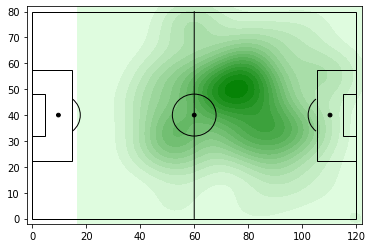

In [58]:
# fig=plt.figure() #set up the figures
# fig.set_size_inches(8, 5)
# ax=fig.add_subplot(1,1,1)

fig, ax = plt.subplots()

x_coord = [i[0] for i in df_events_messi["start_pos"]]
y_coord = [i[1] for i in df_events_messi["start_pos"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 16)

draw_pitch(ax) #overlay our different objects on the pitch

plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('on')
plt.show()

<h4> Lionel Messi's heatmap for the match Barcelona vs Real Madrid played on the 6 May,2018 clearly shows that he is a center attacking midfielder who creates play within the opposition's half on the pitch. With respect to Ronaldo, Messi has minimal defensive capabilities. However, he is not a defensive player either. Also, he does not get into the penalty box for scoring.
</h4>

<h1> CR2 (part2) </h1>

In [59]:
#load the json data into pandas dataframe
with open('/users/poojacj/Desktop/adm_hw2/events/events_Italy.json') as data_file:    
    data = json.load(data_file)
df_events_italy = json_normalize(data, sep = "_")

In [60]:
df_events_italy.head(10)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961
5,8,Simple pass,[{'id': 1801}],8306,"[{'y': 15, 'x': 72}, {'y': 25, 'x': 72}]",2575959,Pass,3158,1H,10.376066,85,180423962
6,1,Ground attacking duel,"[{'id': 602}, {'id': 703}, {'id': 1801}]",8327,"[{'y': 25, 'x': 72}, {'y': 64, 'x': 82}]",2575959,Duel,3158,1H,10.796797,11,180423963
7,1,Ground defending duel,"[{'id': 504}, {'id': 701}, {'id': 1802}]",86366,"[{'y': 85, 'x': 36}, {'y': 75, 'x': 28}]",2575959,Duel,3172,1H,11.527556,12,180423976
8,1,Ground defending duel,"[{'id': 601}, {'id': 701}, {'id': 1802}]",20404,"[{'y': 75, 'x': 28}, {'y': 36, 'x': 18}]",2575959,Duel,3172,1H,12.156579,12,180423977
9,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",8327,"[{'y': 64, 'x': 82}, {'y': 18, 'x': 62}]",2575959,Duel,3158,1H,12.418937,11,180423965


In [61]:
#loading the match data
with open('/users/poojacj/Desktop/adm_hw2/matches/matches_Italy.json') as data_file:    
    data = json.load(data_file)
df_matches_italy = json_normalize(data, sep = "_")

In [62]:
#checking for Juventus - Napoli game played on the 22 April 2018
df_matches_italy[df_matches_italy["label"].str.contains("Juventus - Napoli")]

,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId,label,date,...,teamsData_3194_coachId,teamsData_3194_side,teamsData_3194_teamId,teamsData_3194_score,teamsData_3194_scoreP,teamsData_3194_hasFormation,teamsData_3194_formation_bench,teamsData_3194_formation_lineup,teamsData_3194_formation_substitutions,teamsData_3194_scoreHT
41,Played,4406278,34,181248,2018-04-22 18:45:00,3187,,2576295,"Juventus - Napoli, 0 - 1","April 22, 2018 at 8:45:00 PM GMT+2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
#matching the wyId of matches data to matchId of events data to get the appropriate data
df_events_italy  = df_events_italy[df_events_italy["matchId"] == 2576295]

In [64]:
df_events_italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
573095,8,Simple pass,[{'id': 1801}],21385,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 38}]",2576295,Pass,3187,1H,1.265726,85,245487374
573096,8,Simple pass,[{'id': 1801}],3300,"[{'y': 53, 'x': 38}, {'y': 52, 'x': 38}]",2576295,Pass,3187,1H,2.087491,85,245487375
573097,8,High pass,[{'id': 1802}],25726,"[{'y': 52, 'x': 38}, {'y': 100, 'x': 82}]",2576295,Pass,3187,1H,3.184110,83,245487376
573098,5,Ball out of the field,[],0,"[{'y': 100, 'x': 82}, {'y': 100, 'x': 100}]",2576295,Interruption,3187,1H,7.898538,50,245487378
573099,3,Throw in,[{'id': 1801}],20588,"[{'y': 0, 'x': 17}, {'y': 35, 'x': 3}]",2576295,Free Kick,3159,1H,11.326685,36,245487369
...,...,...,...,...,...,...,...,...,...,...,...,...
574823,3,Free Kick,[{'id': 1801}],7949,"[{'y': 50, 'x': 17}, {'y': 12, 'x': 74}]",2576295,Free Kick,3187,2H,2936.285468,31,245489177
574824,1,Air duel,"[{'id': 701}, {'id': 1802}]",99452,"[{'y': 12, 'x': 74}, {'y': 14, 'x': 65}]",2576295,Duel,3187,2H,2939.176668,10,245489178
574825,1,Air duel,"[{'id': 703}, {'id': 1801}]",20465,"[{'y': 88, 'x': 26}, {'y': 86, 'x': 35}]",2576295,Duel,3159,2H,2939.432014,10,245488988
574826,8,Head pass,"[{'id': 1401}, {'id': 1801}]",99902,"[{'y': 14, 'x': 65}, {'y': 6, 'x': 68}]",2576295,Pass,3187,2H,2941.102559,82,245489179


In [65]:
#considering only passes
df_events_italy = df_events_italy[df_events_italy["eventId"] == 8]

In [66]:
df_events_italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
573095,8,Simple pass,[{'id': 1801}],21385,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 38}]",2576295,Pass,3187,1H,1.265726,85,245487374
573096,8,Simple pass,[{'id': 1801}],3300,"[{'y': 53, 'x': 38}, {'y': 52, 'x': 38}]",2576295,Pass,3187,1H,2.087491,85,245487375
573097,8,High pass,[{'id': 1802}],25726,"[{'y': 52, 'x': 38}, {'y': 100, 'x': 82}]",2576295,Pass,3187,1H,3.184110,83,245487376
573100,8,Simple pass,[{'id': 1801}],20461,"[{'y': 35, 'x': 3}, {'y': 76, 'x': 8}]",2576295,Pass,3159,1H,13.179059,85,245487370
573101,8,Simple pass,[{'id': 1801}],20579,"[{'y': 76, 'x': 8}, {'y': 93, 'x': 13}]",2576295,Pass,3159,1H,15.953909,85,245487371
...,...,...,...,...,...,...,...,...,...,...,...,...
574819,8,Simple pass,[{'id': 1801}],25437,"[{'y': 65, 'x': 73}, {'y': 64, 'x': 73}]",2576295,Pass,3159,2H,2895.696896,85,245488981
574820,8,Head pass,[{'id': 1801}],20443,"[{'y': 64, 'x': 73}, {'y': 97, 'x': 72}]",2576295,Pass,3159,2H,2897.428025,82,245488982
574821,8,Cross,"[{'id': 402}, {'id': 801}, {'id': 1802}]",20751,"[{'y': 97, 'x': 72}, {'y': 49, 'x': 85}]",2576295,Pass,3159,2H,2899.193081,80,245488983
574826,8,Head pass,"[{'id': 1401}, {'id': 1801}]",99902,"[{'y': 14, 'x': 65}, {'y': 6, 'x': 68}]",2576295,Pass,3187,2H,2941.102559,82,245489179


In [67]:
#checking the wyId of Jorginho
df_player[df_player["firstName"] == "Jorge Luiz"]

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea_id,passportArea_alpha3code,passportArea_alpha2code,role_code2,role_code3,role_name,birthArea_name,birthArea_id,birthArea_alpha3code,birthArea_alpha2code
1658,65,Jorge Luiz,,Frello Filho,3187,1991-12-20,180,21315,right,Jorginho,...,380,ITA,IT,MD,MID,Midfielder,Brazil,76,BRA,BR


In [68]:
#checking the wyId of Miralem Pjanic
df_player[df_player["firstName"] == "Miralem"]

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea_id,passportArea_alpha3code,passportArea_alpha2code,role_code2,role_code3,role_name,birthArea_name,birthArea_id,birthArea_alpha3code,birthArea_alpha2code
1482,74,Miralem,,Pjani\u0107,3159,1990-04-02,180,20443,right,M. Pjani\u0107,...,442,LUX,LU,MD,MID,Midfielder,Bosnia-Herzegovina,70,BIH,BA


In [69]:
#considering only the events by Jorginho
df_events_italy = df_events_italy[(df_events_italy["playerId"] == 21315) | (df_events_italy["playerId"] == 20443)]

In [70]:
df_events_italy

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
573105,8,Simple pass,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,1H,26.160914,85,245487395
573107,8,High pass,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,1H,33.120179,83,245487399
573126,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,1H,120.169376,85,245487410
573145,8,Simple pass,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,1H,166.338197,85,245487404
573164,8,Head pass,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,1H,206.466357,82,245487433
...,...,...,...,...,...,...,...,...,...,...,...,...
574742,8,Simple pass,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,2H,2553.325865,85,245489142
574769,8,High pass,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,2H,2608.096907,83,245489158
574778,8,Simple pass,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,2H,2733.388160,85,245488935
574794,8,Simple pass,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,2H,2778.815591,85,245488959


In [71]:
#separating out the position values for Miralem Pjanic and Jorginho
filtered_data_start_pos_mj = []
filtered_data_end_pos_mj = []
for i,x in df_events_italy['positions'].items():
    filtered_data_start_pos_mj.append({'index': i, 'start_pos': x[0]})
    filtered_data_end_pos_mj.append({'index': i, 'start_pos': x[1]}) 

In [72]:
filtered_data_start_pos_mj = pd.DataFrame(filtered_data_start_pos_mj)
filtered_data_end_pos_mj = pd.DataFrame(filtered_data_end_pos_mj)

In [73]:
#setting the index 
filtered_data_start_pos_mj = filtered_data_start_pos_mj.set_index('index')
filtered_data_end_pos_mj = filtered_data_end_pos_mj.set_index('index') 

In [74]:
#merge events and filtered position dataframes on index
df_events_italy = df_events_italy.merge(filtered_data_start_pos_mj, left_index=True, right_index=True)

In [75]:
#merge events and filtered position dataframes on index
df_events_italy = df_events_italy.merge(filtered_data_end_pos_mj, left_index=True, right_index=True)

In [76]:
df_events_italy.drop(['eventId','subEventName','matchPeriod','eventSec','subEventId'], axis=1, inplace=True)

In [77]:
df_events_italy

,tags,playerId,positions,matchId,eventName,teamId,id,start_pos_x,start_pos_y
573105,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}"
573107,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}"
573126,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}"
573145,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}"
573164,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,245487433,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}"
...,...,...,...,...,...,...,...,...,...
574742,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,245489142,"{'y': 28, 'x': 71}","{'y': 21, 'x': 71}"
574769,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,245489158,"{'y': 45, 'x': 67}","{'y': 11, 'x': 80}"
574778,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,245488935,"{'y': 50, 'x': 50}","{'y': 51, 'x': 34}"
574794,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,245488959,"{'y': 44, 'x': 47}","{'y': 63, 'x': 45}"


In [78]:
#rename the column names
df_events_italy.columns = ['tags','playerId','positions','matchId','eventName','teamId','id','start_position','end_position']

In [79]:
#rescaling the x and y coordinates
x_y_pos_start_mj = []
for i,j in df_events_italy["start_position"].items():
    x_y_pos_start_mj.append({'index': i, 'start_pos': [j['x']*1.2,j['y']*0.8]})

In [80]:
start_pos_mj = pd.DataFrame(x_y_pos_start_mj)

In [81]:
start_pos_mj

,index,start_pos
0,573105,"[33.6, 44.0]"
1,573107,"[37.199999999999996, 24.0]"
2,573126,"[75.6, 49.6]"
3,573145,"[56.4, 60.0]"
4,573164,"[85.2, 35.2]"
...,...,...
153,574742,"[85.2, 22.400000000000002]"
154,574769,"[80.39999999999999, 36.0]"
155,574778,"[60.0, 40.0]"
156,574794,"[56.4, 35.2]"


In [82]:
#setting the index 
start_pos_mj = start_pos_mj.set_index('index')

In [83]:
#merge teams and filtered dataframes on index
df_events_italy = df_events_italy.merge(start_pos_mj, left_index=True, right_index=True)

In [84]:
df_events_italy

,tags,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos
573105,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}","[33.6, 44.0]"
573107,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}","[37.199999999999996, 24.0]"
573126,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}","[75.6, 49.6]"
573145,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}","[56.4, 60.0]"
573164,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,245487433,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}","[85.2, 35.2]"
...,...,...,...,...,...,...,...,...,...,...
574742,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,245489142,"{'y': 28, 'x': 71}","{'y': 21, 'x': 71}","[85.2, 22.400000000000002]"
574769,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,245489158,"{'y': 45, 'x': 67}","{'y': 11, 'x': 80}","[80.39999999999999, 36.0]"
574778,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,245488935,"{'y': 50, 'x': 50}","{'y': 51, 'x': 34}","[60.0, 40.0]"
574794,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,245488959,"{'y': 44, 'x': 47}","{'y': 63, 'x': 45}","[56.4, 35.2]"


In [85]:
#rescaling the x and y coordinates
x_y_pos_end_mj = []
for i,j in df_events_italy["end_position"].items():
    x_y_pos_end_mj.append({'index': i, 'end_pos': [j['x']*1.2,j['y']*0.8]})

In [86]:
end_pos_mj = pd.DataFrame(x_y_pos_end_mj)

In [87]:
end_pos_mj

,index,end_pos
0,573105,"[46.8, 1.6]"
1,573107,"[37.199999999999996, 67.2]"
2,573126,"[75.6, 37.6]"
3,573145,"[74.39999999999999, 56.800000000000004]"
4,573164,"[82.8, 33.6]"
...,...,...
153,574742,"[85.2, 16.8]"
154,574769,"[96.0, 8.8]"
155,574778,"[40.8, 40.800000000000004]"
156,574794,"[54.0, 50.400000000000006]"


In [88]:
#setting the index 
end_pos_mj = end_pos_mj.set_index('index')

In [89]:
#merge teams and filtered dataframes on index
df_events_italy = df_events_italy.merge(end_pos_mj, left_index=True, right_index=True)

In [90]:
df_events_italy

,tags,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos,end_pos
573105,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}","[33.6, 44.0]","[46.8, 1.6]"
573107,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}","[37.199999999999996, 24.0]","[37.199999999999996, 67.2]"
573126,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}","[75.6, 49.6]","[75.6, 37.6]"
573145,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}","[56.4, 60.0]","[74.39999999999999, 56.800000000000004]"
573164,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,245487433,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}","[85.2, 35.2]","[82.8, 33.6]"
...,...,...,...,...,...,...,...,...,...,...,...
574742,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,245489142,"{'y': 28, 'x': 71}","{'y': 21, 'x': 71}","[85.2, 22.400000000000002]","[85.2, 16.8]"
574769,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,245489158,"{'y': 45, 'x': 67}","{'y': 11, 'x': 80}","[80.39999999999999, 36.0]","[96.0, 8.8]"
574778,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,245488935,"{'y': 50, 'x': 50}","{'y': 51, 'x': 34}","[60.0, 40.0]","[40.8, 40.800000000000004]"
574794,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,245488959,"{'y': 44, 'x': 47}","{'y': 63, 'x': 45}","[56.4, 35.2]","[54.0, 50.400000000000006]"


In [91]:
#add another column in the dataframe called "AccuratePass" as 1 if tags = 703 otherwise 0
filtered_data_italy = []
for i,x in df_events_italy['tags'].items():
    for j in x:
        if j['id'] == 1801:
            filtered_data_italy.append({'index': i, 'tags': x, 'AccuratePass': int(1)})
        elif j['id'] == 1802:
            filtered_data_italy.append({'index': i, 'tags': x, 'AccuratePass': int(0)})

In [92]:
filtered_data_italy

[{'index': 573105, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573107, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573126, 'tags': [{'id': 1401}, {'id': 1801}], 'AccuratePass': 1},
 {'index': 573145, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573164, 'tags': [{'id': 1401}, {'id': 1802}], 'AccuratePass': 0},
 {'index': 573188, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573220,
  'tags': [{'id': 1401}, {'id': 1001}, {'id': 1802}],
  'AccuratePass': 0},
 {'index': 573225, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573231, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573234, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573237, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573242, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573247, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573256, 'tags': [{'id': 1801}], 'AccuratePass': 1},
 {'index': 573258, 'tags': [{'id': 1801}], 'AccuratePass':

In [93]:
filtered_data_italy = pd.DataFrame(filtered_data_italy)

In [94]:
#setting the index 
filtered_data_italy = filtered_data_italy.set_index('index')

In [95]:
filtered_data_italy

,tags,AccuratePass
index,,
573105,[{'id': 1801}],1
573107,[{'id': 1801}],1
573126,"[{'id': 1401}, {'id': 1801}]",1
573145,[{'id': 1801}],1
573164,"[{'id': 1401}, {'id': 1802}]",0
...,...,...
574742,[{'id': 1801}],1
574769,[{'id': 1801}],1
574778,[{'id': 1801}],1


In [96]:
#merge events and filtered dataframes on index
df_events_italy = df_events_italy.merge(filtered_data_italy, left_index=True, right_index=True)

In [97]:
df_events_italy

,tags_x,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos,end_pos,tags_y,AccuratePass
573105,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}","[33.6, 44.0]","[46.8, 1.6]",[{'id': 1801}],1
573107,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}","[37.199999999999996, 24.0]","[37.199999999999996, 67.2]",[{'id': 1801}],1
573126,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}","[75.6, 49.6]","[75.6, 37.6]","[{'id': 1401}, {'id': 1801}]",1
573145,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}","[56.4, 60.0]","[74.39999999999999, 56.800000000000004]",[{'id': 1801}],1
573164,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,245487433,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}","[85.2, 35.2]","[82.8, 33.6]","[{'id': 1401}, {'id': 1802}]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574742,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,245489142,"{'y': 28, 'x': 71}","{'y': 21, 'x': 71}","[85.2, 22.400000000000002]","[85.2, 16.8]",[{'id': 1801}],1
574769,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,245489158,"{'y': 45, 'x': 67}","{'y': 11, 'x': 80}","[80.39999999999999, 36.0]","[96.0, 8.8]",[{'id': 1801}],1
574778,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,245488935,"{'y': 50, 'x': 50}","{'y': 51, 'x': 34}","[60.0, 40.0]","[40.8, 40.800000000000004]",[{'id': 1801}],1
574794,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,245488959,"{'y': 44, 'x': 47}","{'y': 63, 'x': 45}","[56.4, 35.2]","[54.0, 50.400000000000006]",[{'id': 1801}],1


In [98]:
df_events_italy

,tags_x,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos,end_pos,tags_y,AccuratePass
573105,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}","[33.6, 44.0]","[46.8, 1.6]",[{'id': 1801}],1
573107,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}","[37.199999999999996, 24.0]","[37.199999999999996, 67.2]",[{'id': 1801}],1
573126,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}","[75.6, 49.6]","[75.6, 37.6]","[{'id': 1401}, {'id': 1801}]",1
573145,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}","[56.4, 60.0]","[74.39999999999999, 56.800000000000004]",[{'id': 1801}],1
573164,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,245487433,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}","[85.2, 35.2]","[82.8, 33.6]","[{'id': 1401}, {'id': 1802}]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574742,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,245489142,"{'y': 28, 'x': 71}","{'y': 21, 'x': 71}","[85.2, 22.400000000000002]","[85.2, 16.8]",[{'id': 1801}],1
574769,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,245489158,"{'y': 45, 'x': 67}","{'y': 11, 'x': 80}","[80.39999999999999, 36.0]","[96.0, 8.8]",[{'id': 1801}],1
574778,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,245488935,"{'y': 50, 'x': 50}","{'y': 51, 'x': 34}","[60.0, 40.0]","[40.8, 40.800000000000004]",[{'id': 1801}],1
574794,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,245488959,"{'y': 44, 'x': 47}","{'y': 63, 'x': 45}","[56.4, 35.2]","[54.0, 50.400000000000006]",[{'id': 1801}],1


In [99]:
#considering only Miralem Pjanic
df_Miralem_Pjanic = df_events_italy[df_events_italy["playerId"] == 20443]

In [100]:
#considering only Jorginho
df_Jorginho = df_events_italy[df_events_italy["playerId"] == 21315]

In [101]:
df_events_italy_accurate = df_events_italy[df_events_italy["AccuratePass"] == 1]

In [102]:
df_events_italy_accurate

,tags_x,playerId,positions,matchId,eventName,teamId,id,start_position,end_position,start_pos,end_pos,tags_y,AccuratePass
573105,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}","[33.6, 44.0]","[46.8, 1.6]",[{'id': 1801}],1
573107,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}","[37.199999999999996, 24.0]","[37.199999999999996, 67.2]",[{'id': 1801}],1
573126,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}","[75.6, 49.6]","[75.6, 37.6]","[{'id': 1401}, {'id': 1801}]",1
573145,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}","[56.4, 60.0]","[74.39999999999999, 56.800000000000004]",[{'id': 1801}],1
573188,[{'id': 1801}],21315,"[{'y': 72, 'x': 47}, {'y': 96, 'x': 61}]",2576295,Pass,3187,245487461,"{'y': 72, 'x': 47}","{'y': 96, 'x': 61}","[56.4, 57.6]","[73.2, 76.80000000000001]",[{'id': 1801}],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574742,[{'id': 1801}],21315,"[{'y': 28, 'x': 71}, {'y': 21, 'x': 71}]",2576295,Pass,3187,245489142,"{'y': 28, 'x': 71}","{'y': 21, 'x': 71}","[85.2, 22.400000000000002]","[85.2, 16.8]",[{'id': 1801}],1
574769,[{'id': 1801}],21315,"[{'y': 45, 'x': 67}, {'y': 11, 'x': 80}]",2576295,Pass,3187,245489158,"{'y': 45, 'x': 67}","{'y': 11, 'x': 80}","[80.39999999999999, 36.0]","[96.0, 8.8]",[{'id': 1801}],1
574778,[{'id': 1801}],20443,"[{'y': 50, 'x': 50}, {'y': 51, 'x': 34}]",2576295,Pass,3159,245488935,"{'y': 50, 'x': 50}","{'y': 51, 'x': 34}","[60.0, 40.0]","[40.8, 40.800000000000004]",[{'id': 1801}],1
574794,[{'id': 1801}],20443,"[{'y': 44, 'x': 47}, {'y': 63, 'x': 45}]",2576295,Pass,3159,245488959,"{'y': 44, 'x': 47}","{'y': 63, 'x': 45}","[56.4, 35.2]","[54.0, 50.400000000000006]",[{'id': 1801}],1


In [103]:
#considering only Miralem Pjanic
df_Miralem_Pjanic_accurate = df_events_italy_accurate[df_events_italy_accurate["playerId"] == 20443]

In [104]:
#considering only Jorginho
df_Jorginho_accurate = df_events_italy_accurate[df_events_italy_accurate["playerId"] == 21315]

In [105]:
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = patches.Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = patches.Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = patches.Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = patches.ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = patches.Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = patches.Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = patches.Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = patches.Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

<h1> Passmap of Jorginho (in red) and Miralem Pjanic (in blue) for all passes </h1>

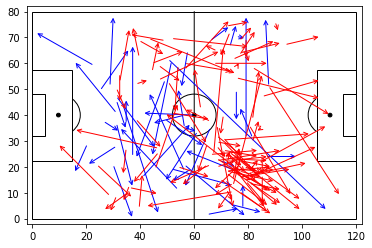

In [106]:
fig, ax = plt.subplots()


draw_pitch(ax) #overlay our different objects on the pitch

for i in range(len(df_Miralem_Pjanic)):
    # annotate draw an arrow from a current position to pass_end_location
    ax.annotate("", xy = (df_Miralem_Pjanic.iloc[i]['end_pos'][0], df_Miralem_Pjanic.iloc[i]['end_pos'][1]), xycoords = 'data',
               xytext = (df_Miralem_Pjanic.iloc[i]['start_pos'][0], df_Miralem_Pjanic.iloc[i]['start_pos'][1]), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
    
for i in range(len(df_Jorginho)):
    # annotate draw an arrow from a current position to pass_end_location
    ax.annotate("", xy = (df_Jorginho.iloc[i]['end_pos'][0], df_Jorginho.iloc[i]['end_pos'][1]), xycoords = 'data',
               xytext = (df_Jorginho.iloc[i]['start_pos'][0], df_Jorginho.iloc[i]['start_pos'][1]), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))

plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('on')
plt.show()

<h4> Jorginho is a right attacking midfielder who supplies passes to the forwards. He rotates the ball by passing to his teammates across the midfield. Pjanic is an attacking midfielder with minimal passes in the defence. With respect to Jorginho he rotates the ball more in the midfield of the opposition's half. Also, he does not supply the ball to the forwards. </h4>

<h1> Passmap of Jorginho (in red) and Miralem Pjanic (in blue) for accurate passes </h1>

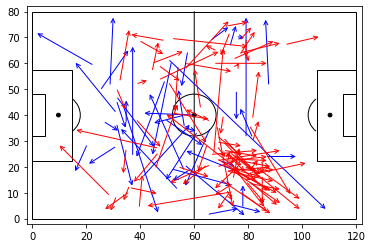

In [107]:
fig, ax = plt.subplots()

draw_pitch(ax) #overlay our different objects on the pitch

for i in range(len(df_Miralem_Pjanic_accurate)):
    # annotate draw an arrow from a current position to pass_end_location
    ax.annotate("", xy = (df_Miralem_Pjanic_accurate.iloc[i]['end_pos'][0], df_Miralem_Pjanic_accurate.iloc[i]['end_pos'][1]), xycoords = 'data',
               xytext = (df_Miralem_Pjanic_accurate.iloc[i]['start_pos'][0], df_Miralem_Pjanic_accurate.iloc[i]['start_pos'][1]), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
    
for i in range(len(df_Jorginho_accurate)):    
    ax.annotate("", xy = (df_Jorginho_accurate.iloc[i]['end_pos'][0], df_Jorginho_accurate.iloc[i]['end_pos'][1]), xycoords = 'data',
               xytext = (df_Jorginho_accurate.iloc[i]['start_pos'][0], df_Jorginho_accurate.iloc[i]['start_pos'][1]), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"))  

plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('on')
plt.show()

<h4> In the above heatmap which shows the accurate passes, it suggests that Jorginho was not successful while providing the pass to the forwads while Pjanic did not even attempt that. </h4>